In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] ='1'



import copy
from jax.scipy.special import logsumexp
from functools import partial
import numpyro.distributions as dist
#import jax.numpy.fft as fft
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import numpy as np
import numpyro
from numpyro.handlers import condition
from pathlib import Path
import diffrax
import os,sys
import pickle
from diffrax import LeapfrogMidpoint, ODETerm, SaveAt, diffeqsolve, ConstantStepSize
from jax.scipy.ndimage import map_coordinates
from jax_cosmo.scipy.integrate import simps
from jaxpm.pm import growth_factor, growth_rate, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel
from jaxpm.painting import cic_paint, cic_paint_2d, cic_read, compensate_cic
from jaxpm.distributed import fft3d, ifft3d, normal_field
from collections import namedtuple
import diffrax
from SuperResPM.configure import Configuration
from jax import tree
from SuperResPM.diffrax_helper import FPMODE,FPMLeapFrog,symplectic_ode
from jaxpm.growth import (dGf2a, dGfa, growth_factor, growth_factor_second,
                          growth_rate, growth_rate_second)
from jaxpm.pm import lpt
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
from blackjax.mcmc.integrators import isokinetic_mclachlan, isokinetic_velocity_verlet, isokinetic_yoshida, isokinetic_omelyan
from functools import partial
from jax import numpy as jnp, random as jr
import jax.numpy as jnp
import jax_cosmo as jc

from jaxpm.distributed import fft3d, ifft3d, normal_field
from jaxpm.growth import (dGf2a, dGfa, growth_factor, growth_factor_second,
                          growth_rate, growth_rate_second)
from jaxpm.kernels import (PGD_kernel, fftk, gradient_kernel,
                           invlaplace_kernel, longrange_kernel)
from jaxpm.painting import cic_paint, cic_paint_dx, cic_read, cic_read_dx
%matplotlib inline 

In [3]:
!nvidia-smi

Sat May 31 17:20:43 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 NVL                On  | 00000000:19:00.0 Off |                    0 |
| N/A   39C    P0              91W / 400W |  95011MiB / 95830MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Some necessary function

In [4]:
def invlowbody(y, low=-jnp.inf, high=jnp.inf):
    cdf_low, cdf_high = norm.cdf(low), norm.cdf(high)
    cdf_x = (norm.cdf(y) - cdf_low) / (cdf_high - cdf_low)
    return norm.ppf(cdf_x)

def invhighbody(y, low=-jnp.inf, high=jnp.inf):
    cdf_nlow, cdf_nhigh = norm.cdf(-low), norm.cdf(-high) # cdf(-x) = 1-cdf(x), more stable
    cdf_nx = (cdf_nhigh - norm.cdf(-y)) / (cdf_nhigh - cdf_nlow)
    return - norm.ppf(cdf_nx)

def invbody(y, low=-jnp.inf, high=jnp.inf):
    condlist = [y < 0.]
    funclist = [invlowbody, invhighbody]
    return jnp.piecewise(y, condlist, funclist, low=low, high=high)

def invhightail(y, low=None, high=jnp.inf):
    temp = 1/6.2842226/2 # best temperature at 12 sigma
    energy, b = jnp.split(jnp.stack(jnp.broadcast_arrays(y, high, 1, -1), axis=0), 2)
    return - temp * logsumexp( - energy / temp, axis=0, b=b)

def invlowtail(y, low=-jnp.inf, high=None):
    temp = 1/6.2842226/2 # best temperature at 12 sigma
    energy, b = jnp.split(jnp.stack(jnp.broadcast_arrays(-y, -low, 1, -1), axis=0), 2)
    return temp * logsumexp( - energy / temp, axis=0, b=b)

def trunc2std(y, loc=0., scale=1., low=-jnp.inf, high=jnp.inf):
    """
    Transport a general truncated normal variable to a standard normal variable.
    """
    y, low, high = (y - loc) / scale, (low - loc) / scale, (high - loc) / scale
    lim = 12 # switch to a more stable approx at 12 sigma, for float32
    condlist = [(y < -lim) & (low < -lim), (lim < y) & (lim < high)]
    funclist = [invlowtail, invhightail, invbody]
    return jnp.piecewise(y, condlist, funclist, low=low, high=high)



def lowtail(x, low=-jnp.inf, high=None):
    temp = 1/6.2842226/2 # best temperature at 12 sigma
    energy = - jnp.stack(jnp.broadcast_arrays(x, low), axis=0)
    return temp * logsumexp( - energy / temp, axis=0)

def hightail(x, low=None, high=jnp.inf):
    temp = 1/6.2842226/2 # best temperature at 12 sigma
    energy = jnp.stack(jnp.broadcast_arrays(x, high), axis=0)
    return - temp * logsumexp( - energy / temp, axis=0)

def lowbody(x, low=-jnp.inf, high=jnp.inf):
    cdf_low, cdf_high = norm.cdf(low), norm.cdf(high)
    cdf_y = cdf_low + (cdf_high - cdf_low) * norm.cdf(x)
    return norm.ppf(cdf_y)

def highbody(x, low=-jnp.inf, high=jnp.inf):
    cdf_nlow, cdf_nhigh = norm.cdf(-low), norm.cdf(-high) # cdf(-x) = 1-cdf(x), more stable
    cdf_ny = cdf_nhigh - (cdf_nhigh - cdf_nlow) * norm.cdf(-x)
    return - norm.ppf(cdf_ny)

def body(x, low=-jnp.inf, high=jnp.inf):
    condlist = [x < 0.]
    funclist = [lowbody, highbody]
    return jnp.piecewise(x, condlist, funclist, low=low, high=high)
def std2trunc(x, loc=0., scale=1., low=-jnp.inf, high=jnp.inf):
    """
    Transport standard normal variable to a general truncated normal variable.
    """
    if scale==0:
        return loc * jnp.ones_like(x)
    low, high = (low - loc) / scale, (high - loc) / scale
    lim = 12 # switch to a more stable approx at 12 sigma, for float32
    condlist = [(x < -lim) & (low < -lim), (lim < x) & (lim < high)]
    funclist = [lowtail, hightail, body]
    return loc + scale * jnp.piecewise(x, condlist, funclist, low=low, high=high)
#############################
# Fourier reparametrization #
#############################
def _rg2cgh(mesh, part="real", norm="backward"):
    """
    Return the real and imaginary parts of a complex Gaussian Hermitian tensor
    obtained by permuting and reweighting a real Gaussian tensor (3D).
    Handle the Hermitian symmetry, specifically at border faces, edges, and vertices.
    """
    shape = np.array(mesh.shape)
    assert np.all(shape % 2 == 0), "dimension lengths must be even."
    
    hx, hy, hz = shape // 2
    meshk = jnp.zeros(r2chshape(shape))
    if part == "imag":
        slix, sliy, sliz = slice(hx + 1, None), slice(hy + 1, None), slice(hz + 1, None)
    else:
        assert part == "real", "part must be either 'real' or 'imag'."
        slix, sliy, sliz = slice(1, hx), slice(1, hy), slice(1, hz)
    meshk = meshk.at[:, :, 1:-1].set(mesh[:, :, sliz])
        
    for k in [0, hz]:  # two faces
        meshk = meshk.at[:, 1:hy, k].set(mesh[:, sliy, k])
        meshk = meshk.at[1:, hy + 1:, k].set(mesh[1:, sliy, k][::-1, ::-1])
        meshk = meshk.at[0, hy + 1:, k].set(mesh[0, sliy, k][::-1])  # handle the border
        if part == "imag" and norm != "amp":
            meshk = meshk.at[:, hy + 1:, k].multiply(-1.)

        for j in [0, hy]:  # two edges per face
            meshk = meshk.at[1:hx, j, k].set(mesh[slix, j, k])
            meshk = meshk.at[hx + 1:, j, k].set(mesh[slix, j, k][::-1])
            if part == "imag" and norm != "amp":
                meshk = meshk.at[hx + 1:, j, k].multiply(-1.)

            for i in [0, hx]:  # two points per edge
                if part == "real":
                    meshk = meshk.at[i, j, k].set(mesh[i, j, k])
                    if norm != "amp":
                        meshk = meshk.at[i, j, k].multiply(2**.5)

    shape = shape.astype(float)
    if norm == "backward":
        meshk /= (2 / shape.prod())**.5
    elif norm == "forward":
        meshk /= (2 * shape.prod())**.5
    elif norm == "ortho":
        meshk /= 2**.5
    else:
        assert norm == "amp", "norm must be either 'backward', 'forward', 'ortho', or 'amp'."

    return meshk


def _cgh2rg(meshk, part="real", norm="backward"):
    """
    Return the "real" and "imaginary" partitions of a real Gaussian tensor (3D)
    obtained by permuting and reweighting the real or imaginary parts of a 
    complex Gaussian Hermitian tensor.
    Handle the Hermitian symmetry, specifically at border faces, edges, and vertices.
    """
    shape = np.array(ch2rshape(meshk.shape))
    assert np.all(shape % 2 == 0), "dimension lengths must be even."

    hx, hy, hz = shape // 2
    mesh = jnp.zeros(shape)

    if part == "imag":
        slix, sliy, sliz = slice(hx + 1, None), slice(hy + 1, None), slice(hz + 1, None)
    else:
        assert part == "real", "part must be either 'real' or 'imag'."
        slix, sliy, sliz = slice(1, hx), slice(1, hy), slice(1, hz)
    mesh = mesh.at[:, :, sliz].set(meshk[:, :, 1:-1])
        
    for k in [0, hz]:  # two faces
        mesh = mesh.at[:, sliy, k].set(meshk[:, 1:hy, k])
        mesh = mesh.at[1:, sliy, k].set(meshk[1:, hy + 1:, k][::-1, ::-1])
        mesh = mesh.at[0, sliy, k].set(meshk[0, hy + 1:, k][::-1])  # handle the border
        if part == "imag" and norm != "amp":
            mesh = mesh.at[:, sliy, k].multiply(-1.)

        for j in [0, hy]:  # two edges per face
            mesh = mesh.at[slix, j, k].set(meshk[1:hx, j, k])
            mesh = mesh.at[slix, j, k].set(meshk[hx + 1:, j, k][::-1])
            if part == "imag" and norm != "amp":
                mesh = mesh.at[slix, j, k].multiply(-1.)

            for i in [0, hx]:  # two points per edge
                if part == "real":
                    mesh = mesh.at[i, j, k].set(meshk[i, j, k])
                    if norm != "amp":
                        mesh = mesh.at[i, j, k].divide(2**.5)

    shape = shape.astype(float)
    if norm == "backward":
        mesh *= (2 / shape.prod())**.5
    elif norm == "forward":
        mesh *= (2 * shape.prod())**.5
    elif norm == "ortho":
        mesh *= 2**.5
    else:
        assert norm == "amp", "norm must be either 'backward', 'forward', 'ortho', or 'amp'."

    return mesh


def rg2cgh(mesh, norm="backward"):
    """
    Permute and reweight a real Gaussian tensor (3D) into a complex Gaussian Hermitian tensor.
    The output would therefore be distributed as the real Fourier transform of a Gaussian tensor.

    This means that by setting `mean, amp = cgh2rg(meank, norm), cgh2rg(ampk, "amp")`\\
    then `rg2cgh(mean + amp * N(0,I), norm)` is distributed as `meank + ampk * rfftn(N(0,I), norm)`

    In particular `rg2cgh(N(0,I), norm)` is distributed as `rfftn(N(0,I), norm)`
    """
    real = _rg2cgh(mesh, part="real", norm=norm)
    if norm == "amp":
        return real
    else:
        imag = _rg2cgh(mesh, part="imag", norm=norm)
        return real + 1j * imag


def cgh2rg(meshk, norm="backward"):
    """
    Permute and reweight a complex Gaussian Hermitian tensor into a real Gaussian tensor (3D).

    This means that by setting `mean, amp = cgh2rg(meank, norm), cgh2rg(ampk, "amp")`\\
    then `rg2cgh(mean + amp * N(0,I), norm)` is distributed as `meank + ampk * rfftn(N(0,I), norm)`

    In particular `rg2cgh(N(0,I), norm)` is distributed as `rfftn(N(0,I), norm)`
    """
    real = _cgh2rg(meshk.real, part="real", norm=norm)
    if norm == "amp":
        # Give same amplitude to wavevector real and imaginary part
        imag = _cgh2rg(meshk.real, part="imag", norm=norm)
    else:
        imag = _cgh2rg(meshk.imag, part="imag", norm=norm)
    return real + imag


def ch2rshape(kshape):
    """
    Complex Hermitian shape to real shape.
    
    Assume last real shape is even to lift the ambiguity.
    """
    return (*kshape[:2], 2*(kshape[2]-1))

def r2chshape(shape):
    """
    Real shape to complex Hermitian shape.
    """
    return (*shape[:2], shape[2]//2+1)
import jax
import jax.numpy as jnp

import jax
import jax.numpy as jnp
import jax.numpy as jnp

def extract_rfftn_from_fftn_jax(full_fft):
    """
    Extract the rfftn-compatible non-redundant part from a Hermitian-symmetric full FFT result.
    
    Parameters:
    -----------
    full_fft : jnp.ndarray
        Complex-valued FFT output (e.g., from jnp.fft.fftn of real input).
        Shape must be 3D and Hermitian-symmetric along the last axis.
    
    Returns:
    --------
    rfftn_data : jnp.ndarray
        The reduced FFT array matching jnp.fft.rfftn output shape.
    """
    N1, N2, N3 = full_fft.shape
    return full_fft[:, :, :N3//2 + 1]
def reconstruct_fftn_from_rfftn_jax(rfftn_data, original_shape):
    """
    Vectorized reconstruction of full FFT from rfftn result in JAX (3D version).
    
    Parameters:
    -----------
    rfftn_data : jnp.ndarray
        Output from jnp.fft.rfftn on real-valued input.
    original_shape : tuple of ints
        Shape of the original real input (must be 3D).
    
    Returns:
    --------
    full_fft : jnp.ndarray
        Complex-valued array equivalent to jnp.fft.fftn(real_input).
    """
    N1, N2, N3 = original_shape
    full_fft = jnp.zeros((N1, N2, N3), dtype=rfftn_data.dtype)

    # Copy non-redundant part
    full_fft = full_fft.at[:, :, :N3//2 + 1].set(rfftn_data)

    # Compute indices of the redundant part
    i = jnp.arange(N1)
    j = jnp.arange(N2)
    k = jnp.arange(1, N3//2)  # skip k=0 and Nyquist

    # Create 3D grids of indices for the input (non-redundant part)
    ii, jj, kk = jnp.meshgrid(i, j, k, indexing='ij')  # shape (N1, N2, N3//2 - 1)

    # Compute the target indices for Hermitian symmetry
    ii_sym = (-ii) % N1
    jj_sym = (-jj) % N2
    kk_sym = (-kk) % N3

    # Get values to assign (conjugates)
    conj_vals = jnp.conj(rfftn_data[ii, jj, kk])

    # Flatten the arrays for indexed assignment
    full_fft = full_fft.at[
        ii_sym.ravel(), jj_sym.ravel(), kk_sym.ravel()
    ].set(conj_vals.ravel())

    return full_fft


def lpt_chto(cosmo,
        initial_conditions,
        particles=None,
        a=0.1,
        halo_size=0,
        sharding=None,
        order=1):
    """
    Computes first and second order LPT displacement and momentum,
    e.g. Eq. 2 and 3 [Jenkins2010](https://arxiv.org/pdf/0910.0258)
    """
    paint_absolute_pos = particles is not None
    if particles is None:
        particles = jnp.zeros_like(initial_conditions,
                                   shape=(*initial_conditions.shape, 3))
    
    a = jnp.atleast_1d(a)
    E = jnp.sqrt(jc.background.Esqr(cosmo, a))
    delta_k = fft3d(initial_conditions)
    initial_force = pm_forces(particles,
                              delta=delta_k,
                              paint_absolute_pos=paint_absolute_pos,
                              halo_size=halo_size,
                              sharding=sharding)

    gf, cosmo = growth_factor(cosmo, a) 
    #jax.debug.print("gf{x}", x=gf)
    gr, cosmo = growth_rate(cosmo, a)
    dx= gf* initial_force
    p = a**2 *gr  * E * dx
    f = a**2 * E * dGfa(cosmo, a) * initial_force

    return dx, p, f

In [5]:
def build_model(
    linear_field,
    dens_model,
    cubegrid_size,
    cube_size,
):
    @jax.jit
    def model(cosmo, field):
        #cosmoparam = cosmoparaminit[0]
        #init = cosmoparaminit[1]
        cosmoparam = cosmo
        Omega_c, sigma8 = cosmoparam 
        model_cosmo = jc.Cosmology(
            Omega_c=Omega_c,
            sigma8=sigma8,
            Omega_b=0.0492,
            Omega_k=0.0,
            h=0.67,
            n_s=0.96,
            w0=-1.0,
            wa=0.0,
        )
        Workspace = namedtuple('_workspace', ['background_radial_comoving_distance', 'background_growth_factor'])
        model_cosmo._workspace =Workspace(None, None)
        ain=jnp.atleast_1d(1)
        _,model_cosmo = growth_rate(model_cosmo, ain)
        _,model_cosmo =  growth_rate_second(model_cosmo,ain)
        _,model_cosmo= growth_factor(model_cosmo, ain)
        _, model_cosmo= jc.background.radial_comoving_distance(model_cosmo, ain)
    
        # Generate linear field
        def pk_fn(x):
            # Create a small function to generate the matter power spectrum
            k = jnp.logspace(-4, 1, 128)
            pk = jc.power.linear_matter_power(model_cosmo, k)
            return jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
        mesh_shape = [cubegrid_size, cubegrid_size, cubegrid_size]

        lin_field = linear_field(
            [cubegrid_size, cubegrid_size, cubegrid_size],
            [cube_size, cube_size, cube_size],
            pk_fn, fieldin=field
        )
    
        # Evolve the density field
        dens = dens_model(model_cosmo, lin_field)
    
        return dens
    return model
def deconv_paint(mesh, order=2):
    """
    Deconvolve the mesh by the paint kernel of given order.
    """
    if jnp.isrealobj(mesh):
        kvec = rfftk(mesh.shape)
        mesh = jnp.fft.rfftn(mesh)
        mesh /= paint_kernel(kvec, order)
        mesh = jnp.fft.irfftn(mesh)
    else:
        kvec = rfftk(ch2rshape(mesh.shape))
        mesh /= paint_kernel(kvec, order)
    return mesh
def full_field_model_pm(
    cube_size,
    cubegrid_size,
    a_init,
    a_center,
    a_final, 
    dt
):
    @jax.jit
    def forward_model(cosmo, lin_field):
        # Create particles
        particles = jnp.stack(
            jnp.meshgrid(
                *[jnp.arange(s) for s in [cubegrid_size, cubegrid_size, cubegrid_size]]
            ),
            axis=-1,
        ).reshape([-1, 3])
        
        mesh_shape = [cubegrid_size, cubegrid_size, cubegrid_size]
        conf = Configuration(mesh_shape=mesh_shape, 
                     snapshots= a_center[::-1],
                     BoxSize=cube_size, 
                     initial_t0=a_init,
                     final_time =a_final,
                     density_plane_npix = 10,
                     dt0=dt)


        def paint_density(t, y, args):
            # Load positions and apply boundary conditions
            pos = y[0]
            #print(y.shape)
            x = pos[..., 0]
            y = pos[..., 1]
            z = pos[..., 2]

            # Paint all the particles that fall into slice
            ss=args[3].mesh_shape
            density = cic_paint(jnp.zeros(ss),jnp.c_[x, y, z])
            #density = deconv_paint(density, order=2)
            #delta_k = fft3d(density)
            return density-1#delta_k
        
    

        #eps, p, f = lpt(cosmo, lin_field, particles, a=conf.initial_t0)
        #
        #term = tree.map(
        #    FPMODE,
        #    symplectic_ode(conf.mesh_shape, paint_absolute_pos=True)
        #)
        #initforce = pm_forces(
        #    particles + eps,
        #    mesh_shape=mesh_shape,
        #    paint_absolute_pos=True,
        #)* 1.5* cosmo.Omega_m  
        #solver = FPMLeapFrog(initial_t0=conf.initial_t0, final_t1=conf.final_time)
        #saveat = SaveAt(ts=a_center[::-1], fn=paint_density)
        #
        #stepsize_controller = ConstantStepSize()
        #solution = diffeqsolve(
        #    term,
        #    solver,
        #    t0=conf.initial_t0,
        #    t1=conf.final_time,
        #    dt0=conf.dt0,
        #    y0=jnp.stack([particles + eps, p, initforce], axis=0),
        #    args=[cosmo, None, conf.initial_t0, conf, 0, 0],
        #    saveat=saveat,
        #    adjoint=diffrax.ReversibleAdjoint(),
        #    #max_steps=32,
        #    stepsize_controller=stepsize_controller,
        #)        
        #return solution.ys[-1,:,:,:] # Just returning the last snapshot
        eps, p, f = lpt_chto(cosmo, lin_field, particles, a=1.0)
        #jax.debug.print("{x}", x=(eps+particles).shape)
        return paint_density(None, [(eps+particles)%cubegrid_size],[None, None, None, conf])
        #return lin_field
    return forward_model


In [6]:
omegamdict = {
'loc':0.26,
 'scale':0.5,
 'scale_fid':0.02,
 'low': 0.05, # XXX: Omega_m < Omega_b implies nan
 'high': 1.}
sigma8dict = {
    'loc':0.83,
    'scale':0.5,
    'scale_fid':0.02,
    'low': 0.,
    'high':jnp.inf
}
from jax.scipy.stats import norm
def cosmo2base(cosmo, inv=False):
    cosmoreturn = copy.deepcopy(cosmo)
    if not inv:
        push_cosmo_omegam = std2trunc(cosmo['cosmo'][0], omegamdict['loc'], omegamdict['scale_fid'], omegamdict['low'], omegamdict['high'])
        push_cosmo_sigma8 = std2trunc(cosmo['cosmo'][1], sigma8dict['loc'], sigma8dict['scale_fid'], sigma8dict['low'], sigma8dict['high'])
        cosmoreturn['cosmo']=jnp.array([push_cosmo_omegam,push_cosmo_sigma8])
    else:
        push_cosmo_omegam = trunc2std(cosmo['cosmo'][0], omegamdict['loc'], omegamdict['scale_fid'], omegamdict['low'], omegamdict['high'])
        push_cosmo_sigma8 = trunc2std(cosmo['cosmo'][1], sigma8dict['loc'], sigma8dict['scale_fid'], sigma8dict['low'], sigma8dict['high'])
        cosmoreturn['cosmo']=jnp.array([push_cosmo_omegam,push_cosmo_sigma8])
    return cosmoreturn
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
jax.config.update("jax_enable_x64",True)


def linear_field_pm(mesh_shape, box_size, pk, fieldin=None):
    """
    Generate initial conditions.
    """
    # Initialize a random field with one slice on each gpu
    #field = normal_field(mesh_shape, seed=seed, sharding=sharding)]


    mesh = rg2cgh(fieldin)
    field = reconstruct_fftn_from_rfftn_jax(mesh, fieldin.shape)
    #field = fft3d(fieldin)
    
    #jax.debug.print("{x}, {y}", x=field[0,0,0], y=mesh[0,0,0])
    #field = fft3d(fieldin)

    
    kvec = fftk(field)
    kmesh = sum((kk / box_size[i] * mesh_shape[i])**2
                for i, kk in enumerate(kvec))**0.5
    pkmesh = pk(kmesh) * (mesh_shape[0] * mesh_shape[1] * mesh_shape[2]) / (
        box_size[0] * box_size[1] * box_size[2])

    field = field * (pkmesh)**0.5
    field = ifft3d(field)
    return field

# Define cosmology parameters

In [7]:
model_cosmo = jc.Cosmology(
            Omega_c=0.26,
            sigma8=0.83,
            Omega_b=0.0492,
            Omega_k=0.0,
            h=0.67,
            n_s=0.96,
            w0=-1.0,
            wa=0.0,
        )
def pk_fn(x):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(model_cosmo, k)
    return jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

# Declare forward model

In [8]:
#####################################################################################################################
key_number = 1
# Set output directory
dir_out = "./"
Path(dir_out).mkdir(parents=True, exist_ok=True)
# Sim configuration
cube_size = 256. # Mpc/h
cubegrid_size =64  # npix
a_init = 0.05 #t0
a_final = 1 #t1
dt = 0.05 #dt
# Initialize the density model
dens_model = full_field_model_pm(
    cube_size=cube_size,
    cubegrid_size=cubegrid_size,
    a_init = a_init,
    a_center=jnp.linspace(a_init,1,41)[::-1], 
    a_final =a_final,
    dt = dt
)
# Partially fix the forward model
model_fn = build_model(
    linear_field=linear_field_pm,
    dens_model=dens_model,
    cubegrid_size=cubegrid_size,
    cube_size=cube_size,
)
model = lambda x: model_fn(**x)

In [9]:
cosmoparaminit_true = {'cosmo':jnp.array([0.26,0.83]), 'field':normal_field([cubegrid_size,cubegrid_size,cubegrid_size], seed=jax.random.PRNGKey(0), sharding=None)}
box_size = [cube_size, cube_size, cube_size]
#kvec = rfftk(cosmoparaminit_true['field'].shape)
#kmesh2 = sum(kk**2 for kk in kvec)**0.5 /cube_size*cubegrid_size # in Mpc/h
box_size=[cube_size, cube_size, cube_size]
mesh_shape=[cubegrid_size, cubegrid_size, cubegrid_size]
mesh = rg2cgh(cosmoparaminit_true['field'])
mesh = reconstruct_fftn_from_rfftn_jax(mesh, cosmoparaminit_true['field'].shape)
#field = reconstruct_fftn_from_rfftn_jax(mesh, cosmoparaminit_true['field'].shape)
kvec = fftk(mesh)
kmesh = sum((kk / box_size[i] * mesh_shape[i])**2
                for i, kk in enumerate(kvec))**0.5
pkmesh =pk_fn(kmesh) * ( cubegrid_size* cubegrid_size * cubegrid_size) / (
        cube_size**3)*growth_factor(model_cosmo, 1.0)[0]**2
gf, cosmo = growth_factor(model_cosmo, 1.) 
gr, _ = growth_rate(model_cosmo, 1.)

In [11]:
fieldin=cosmoparaminit_true['field']
mesh = rg2cgh(fieldin)
field2 = reconstruct_fftn_from_rfftn_jax(mesh, fieldin.shape)
#field = fft3d(fieldin)

#jax.debug.print("{x}, {y}", x=field[0,0,0], y=mesh[0,0,0])
#field = fft3d(fieldin)

kvec = fftk(field2)
kmesh = sum((kk / box_size[i] * mesh_shape[i])**2
            for i, kk in enumerate(kvec))**0.5
pkmesh = pk_fn(kmesh) * (mesh_shape[0] * mesh_shape[1] * mesh_shape[2]) / (
    box_size[0] * box_size[1] * box_size[2])
field1 = field2 * (pkmesh)**0.5
field_test = ifft3d(field1)

In [13]:
lin_field = linear_field_pm(
    [cubegrid_size, cubegrid_size, cubegrid_size],
    [cube_size, cube_size, cube_size],
    pk_fn, fieldin=cosmoparaminit_true['field']
)

# Get observation

In [20]:
obs = model(jax.lax.stop_gradient(cosmoparaminit_true))+1./np.sqrt(0.25)*jax.random.normal(jax.random.PRNGKey(0),[cubegrid_size,cubegrid_size,cubegrid_size])
#obs = cgh2rg(extract_rfftn_from_fftn_jax(fft3d(obs)))+jax.random.normal(jax.random.PRNGKey(0),[cubegrid_size,cubegrid_size,cubegrid_size])
#obs = ifft3d(((reconstruct_fftn_from_rfftn_jax(rg2cgh(obs), [cubegrid_size,cubegrid_size,cubegrid_size]))))

In [18]:
def get_delta(pos_in):
    delta = np.zeros((cubegrid_size,cubegrid_size,cubegrid_size), dtype=np.float32)
    # construct 3D density field
    MASL.MA(pos_in, delta, cube_size, MAS, verbose=verbose)
    #delta *= Masses[1]
    
    # now check that the mass in the density field is equal to the total mass in the simulation
    #print('%.3e should be equal to\n%.3e'%(np.sum(delta, dtype=np.float64), pos.shape[0]*Masses[1]))
    # at this point, delta contains the effective number of particles in each voxel
    # now compute overdensity and density constrast
    delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0
    return delta

In [19]:
#import MAS_library as MASL
#delta = get_delta(np.array((obs/cubegrid_size*cube_size)%(cube_size), dtype=np.float32))

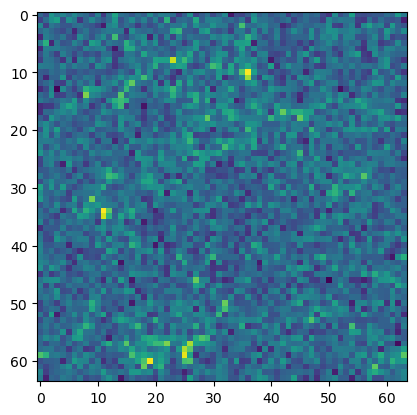

In [20]:
plt.imshow(obs[0])

# Define likelihood

In [17]:
import jax.scipy.stats as stats
def mesh2base(mesh, inv=False):
    A = 1./0.25
    meshreturn = copy.deepcopy(mesh)
    sigma = 1/(gf**2/A+1./(pkmesh))**0.5 /jnp.sqrt(pkmesh)
    mu = fft3d(copy.deepcopy(obs))*sigma**2*gf*jnp.sqrt(pkmesh)/A
    #cgh2rg(extract_rfftn_from_fftn_jax((fft3d(field)/np.sqrt(pkmesh))))
    #
    #mu =  cgh2rg(extract_rfftn_from_fftn_jax((fft3d(obs)/np.sqrt(pkmesh))))#*sigma**2*jnp.sqrt(pkmesh)*100
    if not inv:
        meshreturn['field'] = cgh2rg(extract_rfftn_from_fftn_jax(fft3d(mesh['field'])*sigma+mu))
    else:
        meshreturn['field'] = ifft3d(((reconstruct_fftn_from_rfftn_jax(rg2cgh(mesh['field']), mesh['field'].shape))-mu)/sigma)
    return meshreturn    
@jax.jit
def lnlike(cosmoparam):
    cosmoparamnew = cosmo2base(copy.deepcopy(cosmoparam))
    cosmoparamnew = mesh2base(cosmoparamnew)
    pred= model(cosmoparamnew)
    ngal=0.25#cgh2rg(extract_rfftn_from_fftn_jax(fft3d(obs)))
    #jax.debug.print("{x}", x=jnp.sum(stats.norm.logpdf(obs, pred, 1./np.sqrt(ngal)*jnp.ones_like((pred)))))
    return jnp.sum(stats.norm.logpdf(obs, pred, 1./np.sqrt(ngal)*jnp.ones_like((pred))))+jnp.sum(stats.norm.logpdf(cosmoparamnew['field'],jnp.zeros_like(cosmoparam['field']), jnp.ones_like(cosmoparamnew['field'])))+jnp.sum(stats.norm.logpdf(cosmoparamnew['cosmo'], jnp.array([0.26,0.83]), jnp.array([0.2,1.0])))
@jax.jit
def lnlike_fixedcosmo(cosmoparam):
    cosmoparamnew = copy.deepcopy(cosmoparaminit_true_new)
    cosmoparamnew = cosmo2base(cosmoparamnew)
    cosmoparamnew['field'] = cosmoparam['field']
    cosmoparamnew = mesh2base(cosmoparamnew)
    pred= model(cosmoparamnew)
    ngal=0.25
    return jnp.sum(stats.norm.logpdf(obs,pred, 1./np.sqrt(ngal)*jnp.ones_like((pred))))+jnp.sum(stats.norm.logpdf(cosmoparamnew['field'],jnp.zeros_like(cosmoparam['field']), jnp.ones_like(cosmoparamnew['field'])))+jnp.sum(stats.norm.logpdf(cosmoparamnew['cosmo'], jnp.array([0.26,0.83]), jnp.array([0.2,1.0])))


In [33]:
from jax_tqdm import scan_tqdm
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from blackjax.mcmc.hmc import HMCState
import blackjax
import numpy as np
import matplotlib.pyplot as plt
from jax import lax


In [24]:
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState
def get_mclmc_warmup(logdf, n_steps=None, config=None,
              desired_energy_var=5e-4, diagonal_preconditioning=False, stepsize=None,Length=None):
    return partial(mclmc_warmup,
                   logdf=logdf,
                   n_steps=n_steps,
                   config=config,
                   desired_energy_var=desired_energy_var,
                   diagonal_preconditioning=diagonal_preconditioning)#, stepsize=stepsize, Length=Length)
def mclmc_warmup(rng, init_pos, logdf, n_steps=0, config=None,
              desired_energy_var=5e-4, diagonal_preconditioning=False):
    init_key, tune_key = jr.split(rng, 2)

    # Create an initial state for the sampler
    state = blackjax.mcmc.mclmc.init(
        position=init_pos, logdensity_fn=logdf, rng_key=init_key
    )

    if config is None:
        n_dim = len(ravel_pytree(state.position)[0])
        config = MCLMCAdaptationState(
            n_dim**.5, n_dim**.5 / 4, inverse_mass_matrix=jnp.ones(n_dim))

    elif isinstance(config, dict):
        L = config['L']
        step_size = config['step_size']
        inverse_mass_matrix = config.get('inverse_mass_matrix', 1.0)
        config = MCLMCAdaptationState(L=L, step_size=step_size, inverse_mass_matrix=inverse_mass_matrix)

    else:
        assert isinstance(config, MCLMCAdaptationState), \
        "config must be either None, a dict, or a MCLMCAdaptationState"

    if n_steps > 0:
        # Build the kernel
        kernel = lambda inverse_mass_matrix : blackjax.mcmc.mclmc.build_kernel(
            logdensity_fn=logdf,
            integrator=isokinetic_mclachlan,
            inverse_mass_matrix=inverse_mass_matrix,
        )

        # Find values for L and step_size
        frac_tune1 = 0.5
        frac_tune2 = 0.5
        frac_tune3 = 0.
        # NOTE: can't afford to save every samples to estimate effective sample size, so adapt L afterwards
        num_steps = round(n_steps / (frac_tune1 + frac_tune2 * (1 + diagonal_preconditioning / 3) + frac_tune3))
        # NOTE: num_steps to pass to mclmc_find_L_and_step_size to actually perform n_steps adaptation steps

        state, config, n_steps_tot = blackjax.mclmc_find_L_and_step_size(
            mclmc_kernel=kernel,
            num_steps=num_steps,
            state=state,
            rng_key=tune_key,
            desired_energy_var=desired_energy_var,
            diagonal_preconditioning=diagonal_preconditioning,
            frac_tune1=frac_tune1,
            frac_tune2=frac_tune2,
            frac_tune3=frac_tune3,
            num_effective_samples=256, # NOTE: higher value implies slower averaging rate
            # TODO: add config as first guess (next blackjax update)
            )
        jax.debug.print("Performed {n_steps_tot} adaptation steps", n_steps_tot=n_steps_tot)

    return state, config

In [ ]:
cosmoparaminit_true_new = copy.deepcopy(cosmoparaminit_true)
cosmoparaminit_true_new = cosmo2base(cosmoparaminit_true_new, inv=True)
cosmoparaminit_true_new = mesh2base(cosmoparaminit_true_new, inv=True)

In [32]:
test_param = copy.deepcopy(cosmoparaminit_true)
test_param = cosmo2base(test_param, inv=True)
#test_param = mesh2base(cosmoparaminit_true, inv=True)
test_param['field'] = jnp.zeros_like(mesh2base(test_param, inv=True)['field'])


In [33]:
@jax.jit
def lnlike_fixedcosmo_test(cosmoparam):
    cosmoparamnew = copy.deepcopy(cosmoparaminit_true_new)
    cosmoparamnew = cosmo2base(cosmoparamnew)
    cosmoparamnew['field'] = cosmoparam['field']
    cosmoparamnew = mesh2base(cosmoparamnew)
    pred= model(cosmoparamnew)
    ngal=0.25
    like = jnp.sum(stats.norm.logpdf(obs,pred, 1./np.sqrt(ngal)*jnp.ones_like((pred))))+jnp.sum(stats.norm.logpdf(cosmoparamnew['field'],jnp.zeros_like(cosmoparam['field']), jnp.ones_like(cosmoparamnew['field'])))+jnp.sum(stats.norm.logpdf(cosmoparamnew['cosmo'], jnp.array([0.26,0.83]), jnp.array([0.2,1.0])))

    #jax.debug.print("{x}, {y}", x=cosmoparamnew['cosmo'], y=like)
    return like

# First iteration

In [69]:
from jax import numpy as jnp, random as jr
from jax.flatten_util import ravel_pytree
from blackjax.mcmc.integrators import isokinetic_mclachlan, isokinetic_velocity_verlet, isokinetic_yoshida, isokinetic_omelyan
from functools import partial

warmup_fn = get_mclmc_warmup(lnlike_fixedcosmo_test, n_steps=8192*2, config=None, 
                            desired_energy_var=1e-6, diagonal_preconditioning=False)
state1, config1 = warmup_fn(jr.key(43),test_param)


Performed 16384.0 adaptation steps


In [70]:
test_param = copy.deepcopy(state1.position)
test_param['cosmo']=cosmoparaminit_true_new['cosmo']#jnp.array([0.0,0.0])
test_param = cosmo2base(test_param)
test_param = mesh2base(test_param)
#test_param['field'] = cgh2rg(extract_rfftn_from_fftn_jax((fft3d(obs)/np.sqrt(pkmesh))))#
test = model(jax.lax.stop_gradient(test_param))#+jax.random.normal(jax.random.PRNGKey(0),[cubegrid_size,cubegrid_size,cubegrid_size])

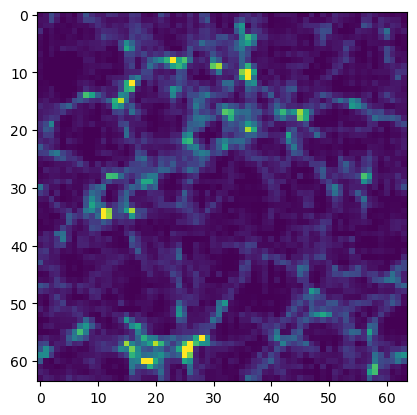

In [71]:
plt.imshow(test[0], vmax=8)

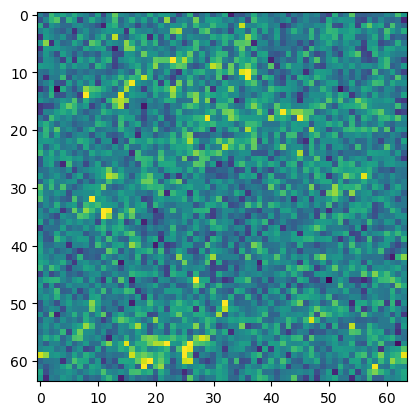

In [72]:
plt.imshow(obs[0], vmax=8)

In [73]:
from jaxpm.utils import pktranscoh
ks, pk0, pk1, t1,t2= pktranscoh(test, obs, box_shape=[cube_size, cube_size, cube_size])

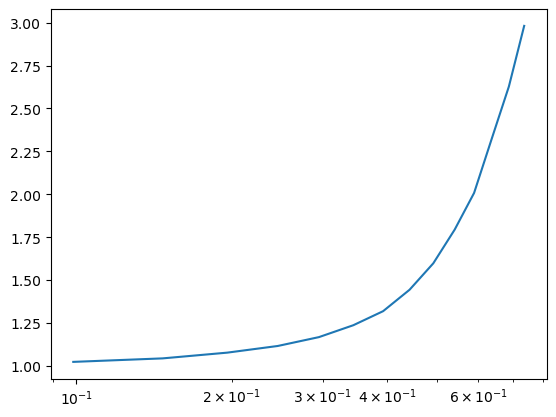

In [74]:
plt.semilogx(ks, t1, label="test")


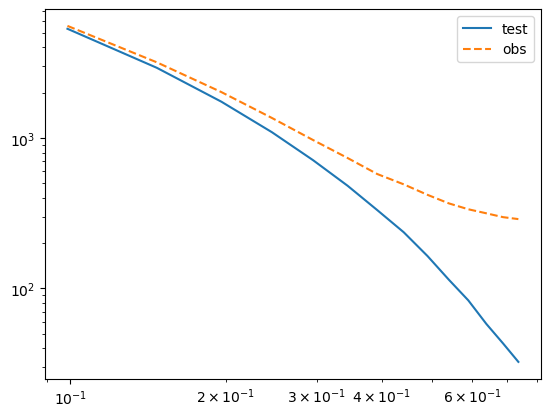

In [75]:
plt.loglog(ks, pk0, label="test")
plt.loglog(ks, pk1, label="obs", ls="--")
plt.legend()

In [41]:
#k, pk = spectrum(obs, box_shape=[cube_size, cube_size, cube_size])

In [76]:
cosmo2base(state1.position)['cosmo']

Array([1.        , 0.38327236], dtype=float64)

(array([4.0000e+00, 1.1000e+01, 1.7000e+01, 6.3000e+01, 3.1900e+02,
        1.7270e+03, 8.4940e+03, 2.7649e+04, 5.6412e+04, 7.1837e+04,
        5.7238e+04, 2.8020e+04, 8.5420e+03, 1.6040e+03, 1.8800e+02,
        1.6000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([-10.        ,  -8.94736842,  -7.89473684,  -6.84210526,
         -5.78947368,  -4.73684211,  -3.68421053,  -2.63157895,
         -1.57894737,  -0.52631579,   0.52631579,   1.57894737,
          2.63157895,   3.68421053,   4.73684211,   5.78947368,
          6.84210526,   7.89473684,   8.94736842,  10.        ]),
 <BarContainer object of 19 artists>)

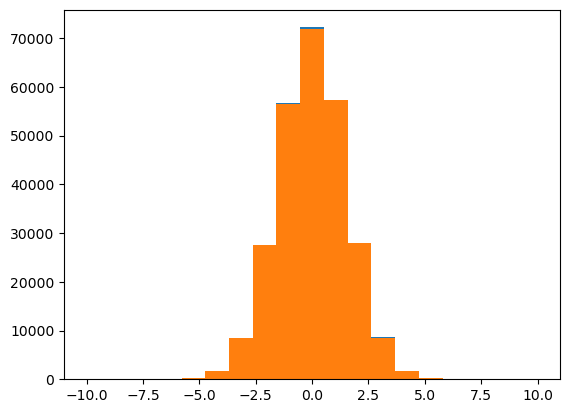

In [77]:
plt.hist(state1.position['field'].flatten(), bins=np.linspace(-10,10,20))
plt.hist(cosmoparaminit_true_new['field'].flatten(),bins=np.linspace(-10,10,20))


# 2nd iteration

In [90]:
newparam = copy.deepcopy(state1.position)
newparam['cosmo']=jnp.array([0.00,0.00])#cosmoparaminit_true_new['cosmo']

In [91]:
@jax.jit
def lnlike_test(cosmoparam):
    cosmoparamnew = cosmo2base(copy.deepcopy(cosmoparam))
    cosmoparamnew = mesh2base(cosmoparamnew)
    pred= model(cosmoparamnew)
    ngal=0.25#cgh2rg(extract_rfftn_from_fftn_jax(fft3d(obs)))
    like=jnp.sum(stats.norm.logpdf(obs, pred, 1./np.sqrt(ngal)*jnp.ones_like((pred))))+jnp.sum(stats.norm.logpdf(cosmoparamnew['field'],jnp.zeros_like(cosmoparam['field']), jnp.ones_like(cosmoparamnew['field'])))+jnp.sum(stats.norm.logpdf(cosmoparamnew['cosmo'], jnp.array([0.26,0.83]), jnp.array([0.2,1.0])))
    jax.debug.print("{x}, {y}", x=cosmoparamnew['cosmo'], y=like)
    return like

In [92]:
from jax import numpy as jnp, random as jr
from jax.flatten_util import ravel_pytree
from blackjax.mcmc.integrators import isokinetic_mclachlan, isokinetic_velocity_verlet, isokinetic_yoshida, isokinetic_omelyan
from functools import partial

warmup_fn = get_mclmc_warmup(lnlike_test, n_steps=4096, config=None, 
                            desired_energy_var=1e-6, diagonal_preconditioning=True)
state2, config2 = warmup_fn(jr.key(43), newparam)


[0.26 0.83], -926456.0921913922
[0.25840453 0.83158974], -926853.253204576
[0.3021348  0.80665583], -930106.4450089043
[0.29564115 0.81129411], -929136.1602828607
[0.28816404 0.81658948], -928166.6187896295
[0.28106164 0.82157997], -927427.3769969307
[0.27344251 0.82689154], -926864.306248007
[0.26933326 0.82974141], -926675.1467835611
[0.26516356 0.83262427], -926572.9933714711
[0.26141776 0.83521303], -926566.6223917132
[0.25768307 0.8377915 ], -926645.4376793201
[0.25382    0.84045517], -926820.8784515456
[0.25004027 0.84306622], -927087.1852982603
[0.24624056 0.84569672], -927453.9165209149
[0.24261383 0.84822536], -927899.4648780457
[0.2391294  0.85067209], -928418.9955079017
[0.23590544 0.85297155], -928982.1828182961
[0.2328807  0.85516031], -929587.8347974368
[0.23019992 0.85716014], -930191.4336527024
[0.22777542 0.85901538], -930794.4946575598
[0.22576706 0.86064758], -931343.0346951357
[0.22402334 0.8621431 ], -931860.3422456516
[0.22277308 0.8633782 ], -932271.3612668384
[0

In [93]:
test_param = copy.deepcopy(state2.position)
#test_param['cosmo']=cosmoparaminit_true_new['cosmo']#jnp.array([0.0,0.0])
test_param = cosmo2base(test_param)
test_param = mesh2base(test_param)
#test_param['field'] = cgh2rg(extract_rfftn_from_fftn_jax((fft3d(obs)/np.sqrt(pkmesh))))#
test = model(jax.lax.stop_gradient(test_param))#+jax.random.normal(jax.random.PRNGKey(0),[cubegrid_size,cubegrid_size,cubegrid_size])

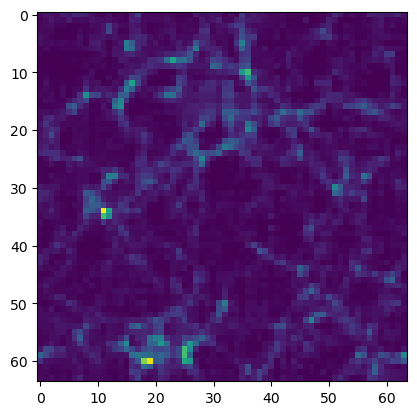

In [94]:
plt.imshow(test[0])

In [95]:
cosmo2base(state2.position)['cosmo']

Array([0.25270586, 0.84145881], dtype=float64)

In [97]:
inverse_mass_matrix = jnp.copy(config2.inverse_mass_matrix)
#inverse_mass_matrix  = inverse_mass_matrix.at[0].set(inverse_mass_matrix[1])

In [98]:
eval_per_ess = 1e3
ss = jnp.median(config2.step_size)
config3 = MCLMCAdaptationState(L=0.4 * eval_per_ess/2 * ss, 
                                step_size=ss, 
                                inverse_mass_matrix=inverse_mass_matrix )

In [101]:
test_param = copy.deepcopy(state2.position)
test_param = cosmo2base(test_param)
test_param = mesh2base(test_param)
#test_param['field'] = cgh2rg(extract_rfftn_from_fftn_jax((fft3d(obs)/np.sqrt(pkmesh))))#
test = model(jax.lax.stop_gradient(test_param))#+jax.random.normal(jax.random.PRNGKey(0),[cubegrid_size,cubegrid_size,cubegrid_size])

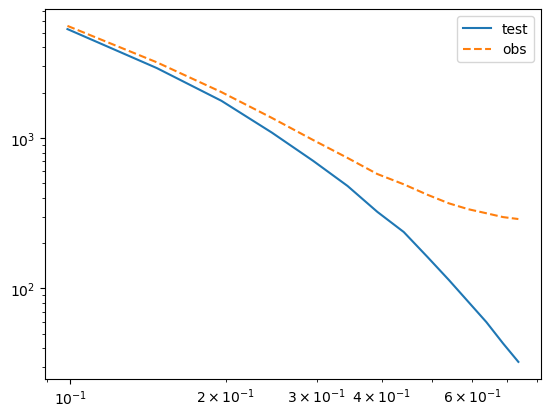

In [102]:
from jaxpm.utils import pktranscoh
ks, pk0, pk1, t1,t2= pktranscoh(test, obs, box_shape=[cube_size, cube_size, cube_size])
plt.loglog(ks, pk0, label="test")
plt.loglog(ks, pk1, label="obs", ls="--")
plt.legend()

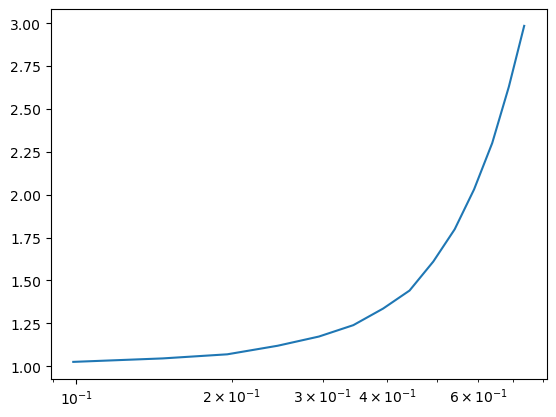

In [103]:
plt.semilogx(ks, t1, label="test")


# Main run

In [114]:
def get_mclmc_run(logdf, n_samples, transform=None, thinning=1, progress_bar=True):
    return partial(mclmc_run, 
                   logdf=logdf,
                   n_samples=n_samples,
                   transform=transform,
                   thinning=thinning,    
                   progress_bar=progress_bar)

def mclmc_run(rng, state, config:dict|MCLMCAdaptationState, logdf, n_samples,
              transform=None, thinning=1, progress_bar=True):
    integrator = isokinetic_mclachlan

    if integrator == isokinetic_velocity_verlet:
        n_eval_per_steps = 1
    elif integrator == isokinetic_mclachlan:
        n_eval_per_steps = 2
    elif integrator == isokinetic_yoshida:
        n_eval_per_steps = 3
    elif integrator == isokinetic_omelyan:
        n_eval_per_steps = 5

    if transform is None:
        n_dim = len(ravel_pytree(state.position)[0])
        transform = lambda state, info: (state.position,
                                    {'logdensity': state.logdensity,
                                     'mse_per_dim': jnp.mean(info.energy_change**2) / n_dim})


    if isinstance(config, dict):
        L = config['L']
        step_size = config['step_size']
        inverse_mass_matrix = config.get('inverse_mass_matrix', 1.0)

    elif isinstance(config, MCLMCAdaptationState):
        L = config.L
        step_size = config.step_size
        inverse_mass_matrix = config.inverse_mass_matrix
    print(config)
    # Use the quick wrapper to build a new kernel with the tuned parameters
    sampler = blackjax.mclmc(logdf, L=L, step_size=step_size,
                            inverse_mass_matrix=inverse_mass_matrix,
                            integrator=integrator,)

    # Run the sampler
    if thinning==1:
        state, history = run_inference_algorithm(
            rng_key=rng,
            initial_state=state,
            inference_algorithm=sampler,
            num_steps=n_samples,
            transform=transform,
            progress_bar=progress_bar,
        )
    else:
        state, history = run_with_thinning(
            rng_key=rng,
            inference_algorithm=sampler,
            num_steps=n_samples,
            initial_state=state,
            transform=transform,
            progress_bar=progress_bar,
            thinning=thinning
        )
    #samples, infos = history

    # Register number of evaluations
    #infos |= {"n_evals": n_eval_per_steps * thinning * jnp.ones(n_samples)}
    return state, history

from functools import partial
from typing import Callable, Union

from blackjax.base import SamplingAlgorithm, VIAlgorithm
from blackjax.progress_bar import progress_bar_scan
from blackjax.types import ArrayLikeTree, PRNGKey

def run_with_thinning(
    rng_key: PRNGKey,
    inference_algorithm: SamplingAlgorithm|VIAlgorithm,
    num_steps: int,
    initial_state: ArrayLikeTree = None,
    initial_position: ArrayLikeTree = None,
    progress_bar: bool = False,
    thinning: int = 1,
    transform: Callable = lambda state, info: (state, info),
) -> tuple:
    """
    Wrapper to run an inference algorithm.

    Note that this utility function does not work for Stochastic Gradient MCMC samplers
    like sghmc, as SG-MCMC samplers require additional control flow for batches of data
    to be passed in during each sample.

    Parameters
    ----------
    rng_key
        The random state used by JAX's random numbers generator.
    initial_state
        The initial state of the inference algorithm.
    initial_position
        The initial position of the inference algorithm. This is used when the initial
        state is not provided.
    inference_algorithm
        One of blackjax's sampling algorithms or variational inference algorithms.
    num_steps
        Number of MCMC steps.
    progress_bar
        Whether to display a progress bar.
    transform
        A transformation of the trace of states to be returned. This is useful for
        computing determinstic variables, or returning a subset of the states.
        By default, the states are returned as is.
    thinning
        The thinning factor, meaning a state is returned every `thinning` steps.
    """

    if initial_state is None and initial_position is None:
        raise ValueError(
            "Either `initial_state` or `initial_position` must be provided."
        )
    if initial_state is not None and initial_position is not None:
        raise ValueError(
            "Only one of `initial_state` or `initial_position` must be provided."
        )

    if initial_state is None:
        rng_key, init_key = jr.split(rng_key, 2)
        initial_state = inference_algorithm.init(initial_position, init_key)

    @jax.jit
    def one_sub_step(state, rng_key):
        state, info = inference_algorithm.step(rng_key, state)
        return state, info
    
    #def one_step(state, xs):
    #    _, rng_key = xs
    #    #keys = jr.split(rng_key, thinning)
    #    state, info = #lax.scan(one_sub_step, state, keys)
    #    return state, transform(state, info)

    keys = jr.split(rng_key, num_steps)
    #xs = jnp.arange(num_steps), keys
    
    #scan_fn = gen_scan_fn(num_steps, progress_bar)
    #final_state, history = scan_fn(one_step, initial_state, xs)

    ys = []
    state = initial_state
    index = 0 
    cpus = jax.devices("cpu")
    gpus = jax.devices("gpu")

    for k in tqdm(keys):
        
        state, y = one_sub_step(state, k)
        #jax.debug.print("{x}", x=state.position['cosmo'])
        #y = jax.jit(lambda y:y, device=gpus[0])(y) 
        p = jax.jit(lambda y:y, device=cpus[0])(state.position) 
        
        if index%thinning==0:
            jax.debug.print("{x}", x=p['cosmo'])
            ys.append(p)
        index += 1
    return state, ys


    #return final_state, history
from tqdm import tqdm
run_fn = get_mclmc_run(lnlike, 150000, progress_bar=True)

In [115]:
key = jax.random.key(0)
init_key, tune_key, run_key = jax.random.split(key, 3)
# create an initial state for the sampler
initial_state = blackjax.mcmc.mclmc.init(
        position=state2.position, logdensity_fn=lnlike, rng_key=init_key
)

In [116]:
lnlike(initial_state.position)

Array(-925663.79700916, dtype=float64)

In [117]:
config3

MCLMCAdaptationState(L=Array(5497.04421451, dtype=float64), step_size=Array(27.48522107, dtype=float64), inverse_mass_matrix=Array([0.77703756, 0.16076012, 1.99407803, ..., 1.57857764, 1.20073507,
       1.28796361], dtype=float64))

In [118]:
from blackjax.progress_bar import gen_scan_fn # XXX: blackjax >= 1.2.3
state, samples = run_fn(jr.key(49), initial_state, config3, thinning=16)

MCLMCAdaptationState(L=Array(5497.04421451, dtype=float64), step_size=Array(27.48522107, dtype=float64), inverse_mass_matrix=Array([0.77703756, 0.16076012, 1.99407803, ..., 1.57857764, 1.20073507,
       1.28796361], dtype=float64))


  0%|▌                                                                                                                                 | 595/150000 [01:47<3:07:53, 13.25it/s]

[-0.59987534 -0.40729964]


  0%|▌                                                                                                                                 | 611/150000 [01:48<3:09:30, 13.14it/s]

[-0.20163121 -0.2913009 ]


  0%|▌                                                                                                                                 | 627/150000 [01:49<3:08:37, 13.20it/s]

[ 0.07700378 -0.30135814]


  0%|▌                                                                                                                                 | 643/150000 [01:50<3:07:34, 13.27it/s]

[0.41564751 0.04017866]


  0%|▌                                                                                                                                 | 659/150000 [01:52<3:10:16, 13.08it/s]

[ 0.28014262 -0.11643124]


  0%|▌                                                                                                                                 | 675/150000 [01:53<3:08:15, 13.22it/s]

[ 0.34508299 -0.19892854]


  0%|▌                                                                                                                                 | 691/150000 [01:54<3:10:57, 13.03it/s]

[ 0.7622964  -0.12810726]


  0%|▌                                                                                                                                 | 707/150000 [01:55<3:09:13, 13.15it/s]

[ 0.66101269 -0.50762968]


  0%|▋                                                                                                                                 | 723/150000 [01:56<3:09:18, 13.14it/s]

[ 1.13191754 -0.40220929]


  0%|▋                                                                                                                                 | 739/150000 [01:58<3:05:57, 13.38it/s]

[ 1.44941329 -0.41454838]


  1%|▋                                                                                                                                 | 755/150000 [01:59<3:08:57, 13.16it/s]

[ 1.39589061 -0.29836848]


  1%|▋                                                                                                                                 | 771/150000 [02:00<3:08:32, 13.19it/s]

[ 1.12174694 -0.3059846 ]


  1%|▋                                                                                                                                 | 787/150000 [02:01<3:09:50, 13.10it/s]

[ 0.71513032 -0.29797629]


  1%|▋                                                                                                                                 | 803/150000 [02:02<3:09:12, 13.14it/s]

[ 0.26981979 -0.33019867]


  1%|▋                                                                                                                                 | 819/150000 [02:04<3:08:43, 13.17it/s]

[-0.00189845 -0.66965611]


  1%|▋                                                                                                                                 | 835/150000 [02:05<3:07:36, 13.25it/s]

[ 0.06545543 -0.10587536]


  1%|▋                                                                                                                                 | 851/150000 [02:06<3:10:52, 13.02it/s]

[-0.33873727 -0.16148088]


  1%|▊                                                                                                                                 | 867/150000 [02:07<3:09:10, 13.14it/s]

[-0.23934996  0.21593501]


  1%|▊                                                                                                                                 | 883/150000 [02:08<3:08:07, 13.21it/s]

[-0.83038346  0.32883285]


  1%|▊                                                                                                                                 | 899/150000 [02:10<3:07:06, 13.28it/s]

[-0.75860772  0.75292304]


  1%|▊                                                                                                                                 | 915/150000 [02:11<3:07:07, 13.28it/s]

[-0.79492031  1.06624662]


  1%|▊                                                                                                                                 | 931/150000 [02:12<3:08:27, 13.18it/s]

[-1.18195783  1.28412917]


  1%|▊                                                                                                                                 | 947/150000 [02:13<3:08:10, 13.20it/s]

[-1.34735345  1.48069898]


  1%|▊                                                                                                                                 | 963/150000 [02:15<3:07:29, 13.25it/s]

[-1.60823027  1.36698066]


  1%|▊                                                                                                                                 | 979/150000 [02:16<3:07:37, 13.24it/s]

[-1.8663601   1.15653654]


  1%|▊                                                                                                                                 | 995/150000 [02:17<3:08:07, 13.20it/s]

[-2.10742569  0.92172864]


  1%|▊                                                                                                                                | 1011/150000 [02:18<3:08:32, 13.17it/s]

[-1.98285533  0.71502417]


  1%|▉                                                                                                                                | 1027/150000 [02:19<3:07:59, 13.21it/s]

[-1.83447335  0.38015591]


  1%|▉                                                                                                                                | 1043/150000 [02:21<3:08:24, 13.18it/s]

[-0.98268937  0.57552713]


  1%|▉                                                                                                                                | 1059/150000 [02:22<3:09:32, 13.10it/s]

[-0.86513602  0.263835  ]


  1%|▉                                                                                                                                | 1075/150000 [02:23<3:06:37, 13.30it/s]

[-0.76144811  0.17123098]


  1%|▉                                                                                                                                | 1091/150000 [02:24<3:09:58, 13.06it/s]

[-0.53859859  0.21856849]


  1%|▉                                                                                                                                | 1107/150000 [02:25<3:07:26, 13.24it/s]

[-0.37263964  0.2176181 ]


  1%|▉                                                                                                                                | 1123/150000 [02:27<3:08:25, 13.17it/s]

[-0.20397673  0.13292418]


  1%|▉                                                                                                                                | 1139/150000 [02:28<3:05:31, 13.37it/s]

[-0.22537362  0.12018506]


  1%|▉                                                                                                                                | 1155/150000 [02:29<3:06:20, 13.31it/s]

[-0.17763979  0.17911798]


  1%|█                                                                                                                                | 1171/150000 [02:30<3:08:53, 13.13it/s]

[-0.20122527 -0.00265171]


  1%|█                                                                                                                                | 1187/150000 [02:31<3:08:17, 13.17it/s]

[-0.35604363  0.18135931]


  1%|█                                                                                                                                | 1203/150000 [02:33<3:08:13, 13.18it/s]

[-0.31134285  0.62365128]


  1%|█                                                                                                                                | 1219/150000 [02:34<3:09:29, 13.09it/s]

[-0.35645751  0.82162446]


  1%|█                                                                                                                                | 1235/150000 [02:35<3:07:43, 13.21it/s]

[-0.31630228  1.06965502]


  1%|█                                                                                                                                | 1251/150000 [02:36<3:08:58, 13.12it/s]

[-0.46197522  0.98340647]


  1%|█                                                                                                                                | 1267/150000 [02:38<3:08:39, 13.14it/s]

[-0.55375421  0.87954873]


  1%|█                                                                                                                                | 1283/150000 [02:39<3:06:55, 13.26it/s]

[-1.0098191   0.70734319]


  1%|█                                                                                                                                | 1299/150000 [02:40<3:07:02, 13.25it/s]

[-0.88525515  0.74692964]


  1%|█▏                                                                                                                               | 1315/150000 [02:41<3:11:39, 12.93it/s]

[-0.46901062  0.66143735]


  1%|█▏                                                                                                                               | 1331/150000 [02:42<3:07:16, 13.23it/s]

[-0.31486489  0.49909382]


  1%|█▏                                                                                                                               | 1347/150000 [02:44<3:07:03, 13.24it/s]

[0.55701698 0.84780026]


  1%|█▏                                                                                                                               | 1363/150000 [02:45<3:06:40, 13.27it/s]

[1.03515484 0.7705567 ]


  1%|█▏                                                                                                                               | 1379/150000 [02:46<3:12:48, 12.85it/s]

[0.73063114 0.26177538]


  1%|█▏                                                                                                                               | 1395/150000 [02:47<3:09:24, 13.08it/s]

[ 0.72220631 -0.07795237]


  1%|█▏                                                                                                                               | 1411/150000 [02:49<3:08:24, 13.14it/s]

[ 0.57972691 -0.58191123]


  1%|█▏                                                                                                                               | 1427/150000 [02:50<3:08:09, 13.16it/s]

[ 0.93153588 -0.66402764]


  1%|█▏                                                                                                                               | 1443/150000 [02:51<3:07:51, 13.18it/s]

[ 1.37490974 -0.53141299]


  1%|█▎                                                                                                                               | 1459/150000 [02:52<3:08:39, 13.12it/s]

[ 1.06020968 -0.64778376]


  1%|█▎                                                                                                                               | 1475/150000 [02:53<3:07:45, 13.18it/s]

[ 1.22570095 -0.36599958]


  1%|█▎                                                                                                                               | 1491/150000 [02:55<3:09:45, 13.04it/s]

[ 1.09507965 -0.43395239]


  1%|█▎                                                                                                                               | 1507/150000 [02:56<3:07:36, 13.19it/s]

[ 1.16300682 -0.36464304]


  1%|█▎                                                                                                                               | 1523/150000 [02:57<3:06:47, 13.25it/s]

[ 1.13051696 -0.26286725]


  1%|█▎                                                                                                                               | 1539/150000 [02:58<3:06:55, 13.24it/s]

[ 0.88361949 -0.19354231]


  1%|█▎                                                                                                                               | 1555/150000 [02:59<3:07:12, 13.22it/s]

[ 0.80234543 -0.12273271]


  1%|█▎                                                                                                                               | 1571/150000 [03:01<3:07:38, 13.18it/s]

[ 0.1761615  -0.30496408]


  1%|█▎                                                                                                                               | 1587/150000 [03:02<3:06:59, 13.23it/s]

[ 0.22263175 -0.29792292]


  1%|█▍                                                                                                                               | 1603/150000 [03:03<3:10:10, 13.00it/s]

[-0.37004251 -0.59541113]


  1%|█▍                                                                                                                               | 1619/150000 [03:04<3:07:16, 13.21it/s]

[-0.5624565  -0.52719158]


  1%|█▍                                                                                                                               | 1635/150000 [03:05<3:06:37, 13.25it/s]

[-0.64601354 -0.35792124]


  1%|█▍                                                                                                                               | 1651/150000 [03:07<3:07:11, 13.21it/s]

[-0.6757556  -0.15764769]


  1%|█▍                                                                                                                               | 1667/150000 [03:08<3:06:40, 13.24it/s]

[-0.68486003  0.0519183 ]


  1%|█▍                                                                                                                               | 1683/150000 [03:09<3:08:51, 13.09it/s]

[-1.19460478 -0.03406047]


  1%|█▍                                                                                                                               | 1699/150000 [03:10<3:09:17, 13.06it/s]

[-1.52998359  0.10082621]


  1%|█▍                                                                                                                               | 1715/150000 [03:12<3:09:44, 13.02it/s]

[-1.59654534  0.34761162]


  1%|█▍                                                                                                                               | 1731/150000 [03:13<3:08:49, 13.09it/s]

[-1.41360631  0.49046754]


  1%|█▌                                                                                                                               | 1747/150000 [03:14<3:06:37, 13.24it/s]

[-1.06728822  0.30594079]


  1%|█▌                                                                                                                               | 1763/150000 [03:15<3:06:52, 13.22it/s]

[-0.55406147  0.20493549]


  1%|█▌                                                                                                                               | 1779/150000 [03:16<3:06:11, 13.27it/s]

[-0.2159253   0.09308124]


  1%|█▌                                                                                                                               | 1795/150000 [03:18<3:07:39, 13.16it/s]

[ 0.73022715 -0.070696  ]


  1%|█▌                                                                                                                               | 1811/150000 [03:19<3:07:08, 13.20it/s]

[ 1.14626621 -0.25168161]


  1%|█▌                                                                                                                               | 1827/150000 [03:20<3:06:47, 13.22it/s]

[ 1.58446204 -0.33496688]


  1%|█▌                                                                                                                               | 1843/150000 [03:21<3:06:24, 13.25it/s]

[ 1.64674279 -0.42846879]


  1%|█▌                                                                                                                               | 1859/150000 [03:22<3:07:40, 13.16it/s]

[ 1.76277768 -0.36325881]


  1%|█▌                                                                                                                               | 1875/150000 [03:24<3:09:08, 13.05it/s]

[ 1.7555421  -0.36332386]


  1%|█▋                                                                                                                               | 1891/150000 [03:25<3:07:53, 13.14it/s]

[ 1.78603156 -0.22291895]


  1%|█▋                                                                                                                               | 1907/150000 [03:26<3:06:01, 13.27it/s]

[ 1.59640964 -0.12059739]


  1%|█▋                                                                                                                               | 1923/150000 [03:27<3:08:10, 13.12it/s]

[ 1.30574043 -0.15763954]


  1%|█▋                                                                                                                               | 1939/150000 [03:28<3:07:01, 13.19it/s]

[ 0.87952863 -0.28028501]


  1%|█▋                                                                                                                               | 1955/150000 [03:30<3:06:59, 13.20it/s]

[ 0.64878297 -0.1245045 ]


  1%|█▋                                                                                                                               | 1971/150000 [03:31<3:07:03, 13.19it/s]

[0.49224701 0.03122662]


  1%|█▋                                                                                                                               | 1987/150000 [03:32<3:05:50, 13.27it/s]

[0.39590178 0.28206827]


  1%|█▋                                                                                                                               | 2003/150000 [03:33<3:08:16, 13.10it/s]

[0.12123401 0.52370636]


  1%|█▋                                                                                                                               | 2019/150000 [03:35<3:05:30, 13.30it/s]

[-0.59640581  0.49016535]


  1%|█▊                                                                                                                               | 2035/150000 [03:36<3:08:27, 13.09it/s]

[-1.15734734  0.74755315]


  1%|█▊                                                                                                                               | 2051/150000 [03:37<3:07:43, 13.13it/s]

[-1.82353416  0.86703058]


  1%|█▊                                                                                                                               | 2067/150000 [03:38<3:06:49, 13.20it/s]

[-2.23236118  0.7358142 ]


  1%|█▊                                                                                                                               | 2083/150000 [03:39<3:07:02, 13.18it/s]

[-2.23002221  0.82178256]


  1%|█▊                                                                                                                               | 2099/150000 [03:41<3:07:50, 13.12it/s]

[-1.97970843  0.9333261 ]


  1%|█▊                                                                                                                               | 2115/150000 [03:42<3:06:50, 13.19it/s]

[-1.66379452  0.75078344]


  1%|█▊                                                                                                                               | 2131/150000 [03:43<3:06:53, 13.19it/s]

[-0.82152886  0.84614118]


  1%|█▊                                                                                                                               | 2147/150000 [03:44<3:05:53, 13.26it/s]

[-0.89796415  0.24976965]


  1%|█▊                                                                                                                               | 2163/150000 [03:45<3:07:22, 13.15it/s]

[-1.33449663 -0.15077079]


  1%|█▊                                                                                                                               | 2179/150000 [03:47<3:05:13, 13.30it/s]

[-1.03173068 -0.16868007]


  1%|█▉                                                                                                                               | 2195/150000 [03:48<3:06:51, 13.18it/s]

[-0.98995104 -0.36592033]


  1%|█▉                                                                                                                               | 2211/150000 [03:49<3:05:46, 13.26it/s]

[-0.77659678 -0.21407814]


  1%|█▉                                                                                                                               | 2227/150000 [03:50<3:05:03, 13.31it/s]

[-0.4220792  -0.13147444]


  1%|█▉                                                                                                                               | 2243/150000 [03:51<3:05:24, 13.28it/s]

[-0.1574671  0.0014804]


  2%|█▉                                                                                                                               | 2259/150000 [03:53<3:06:10, 13.23it/s]

[-0.2876089 -0.1301084]


  2%|█▉                                                                                                                               | 2275/150000 [03:54<3:06:28, 13.20it/s]

[-0.20925797 -0.0884905 ]


  2%|█▉                                                                                                                               | 2291/150000 [03:55<3:07:40, 13.12it/s]

[-0.31338763 -0.14064477]


  2%|█▉                                                                                                                               | 2307/150000 [03:56<3:06:24, 13.21it/s]

[-0.63818918 -0.26656353]


  2%|█▉                                                                                                                               | 2323/150000 [03:58<3:05:12, 13.29it/s]

[-0.55961471 -0.06792999]


  2%|██                                                                                                                               | 2339/150000 [03:59<3:05:29, 13.27it/s]

[-0.61131489  0.02913074]


  2%|██                                                                                                                               | 2355/150000 [04:00<3:04:18, 13.35it/s]

[-0.21610794  0.30604037]


  2%|██                                                                                                                               | 2371/150000 [04:01<3:07:14, 13.14it/s]

[-0.23298073  0.27262317]


  2%|██                                                                                                                               | 2387/150000 [04:02<3:06:14, 13.21it/s]

[0.27077795 0.59384768]


  2%|██                                                                                                                               | 2403/150000 [04:04<3:07:54, 13.09it/s]

[-0.09108079  0.25722098]


  2%|██                                                                                                                               | 2419/150000 [04:05<3:07:29, 13.12it/s]

[-0.23333938  0.21214641]


  2%|██                                                                                                                               | 2435/150000 [04:06<3:06:16, 13.20it/s]

[0.0554252  0.50321148]


  2%|██                                                                                                                               | 2451/150000 [04:07<3:06:21, 13.20it/s]

[-0.29958382  0.11480346]


  2%|██                                                                                                                               | 2467/150000 [04:08<3:06:34, 13.18it/s]

[-0.09092721  0.28251781]


  2%|██▏                                                                                                                              | 2483/150000 [04:10<3:06:12, 13.20it/s]

[-0.21566407  0.26756578]


  2%|██▏                                                                                                                              | 2499/150000 [04:11<3:06:40, 13.17it/s]

[-0.61905116  0.32225377]


  2%|██▏                                                                                                                              | 2515/150000 [04:12<3:05:48, 13.23it/s]

[-1.10079532  0.29841575]


  2%|██▏                                                                                                                              | 2531/150000 [04:13<3:05:47, 13.23it/s]

[-0.99105951  0.59586954]


  2%|██▏                                                                                                                              | 2547/150000 [04:14<3:05:51, 13.22it/s]

[-1.4716169   0.50724449]


  2%|██▏                                                                                                                              | 2563/150000 [04:16<3:06:50, 13.15it/s]

[-1.45971624  0.6601019 ]


  2%|██▏                                                                                                                              | 2579/150000 [04:17<3:07:01, 13.14it/s]

[-1.39880452  0.96238521]


  2%|██▏                                                                                                                              | 2595/150000 [04:18<3:02:53, 13.43it/s]

[-1.21860239  1.11566698]


  2%|██▏                                                                                                                              | 2611/150000 [04:19<3:04:01, 13.35it/s]

[-1.79996305  1.19953283]


  2%|██▎                                                                                                                              | 2627/150000 [04:20<2:59:04, 13.72it/s]

[-2.25259331  1.21809198]


  2%|██▎                                                                                                                              | 2643/150000 [04:22<2:49:01, 14.53it/s]

[-2.20536408  1.04658552]


  2%|██▎                                                                                                                              | 2659/150000 [04:23<2:54:10, 14.10it/s]

[-1.56213758  1.0913346 ]


  2%|██▎                                                                                                                              | 2675/150000 [04:24<2:55:41, 13.98it/s]

[-1.35616943  0.92231604]


  2%|██▎                                                                                                                              | 2691/150000 [04:25<3:03:20, 13.39it/s]

[-1.0404834   0.86200638]


  2%|██▎                                                                                                                              | 2707/150000 [04:26<2:57:46, 13.81it/s]

[-0.8409328   0.63865125]


  2%|██▎                                                                                                                              | 2723/150000 [04:27<2:57:15, 13.85it/s]

[-0.27260782  0.78882619]


  2%|██▎                                                                                                                              | 2739/150000 [04:29<3:06:26, 13.16it/s]

[-0.38179738  0.62333156]


  2%|██▎                                                                                                                              | 2755/150000 [04:30<3:03:41, 13.36it/s]

[-0.24016189  0.43074609]


  2%|██▍                                                                                                                              | 2771/150000 [04:31<3:05:28, 13.23it/s]

[-0.14491568 -0.17152236]


  2%|██▍                                                                                                                              | 2787/150000 [04:32<3:06:58, 13.12it/s]

[ 0.23493482 -0.29938959]


  2%|██▍                                                                                                                              | 2803/150000 [04:33<3:07:39, 13.07it/s]

[ 0.91486683 -0.33071398]


  2%|██▍                                                                                                                              | 2819/150000 [04:35<3:05:00, 13.26it/s]

[ 1.33048241 -0.38641242]


  2%|██▍                                                                                                                              | 2835/150000 [04:36<3:04:18, 13.31it/s]

[ 1.31513012 -0.19970595]


  2%|██▍                                                                                                                              | 2851/150000 [04:37<3:08:41, 13.00it/s]

[ 0.85925863 -0.21605617]


  2%|██▍                                                                                                                              | 2867/150000 [04:38<3:04:57, 13.26it/s]

[0.85302565 0.19183569]


  2%|██▍                                                                                                                              | 2883/150000 [04:39<3:04:31, 13.29it/s]

[0.46578133 0.23878293]


  2%|██▍                                                                                                                              | 2899/150000 [04:41<3:06:27, 13.15it/s]

[0.09397634 0.12644744]


  2%|██▌                                                                                                                              | 2915/150000 [04:42<3:05:35, 13.21it/s]

[-0.07532623  0.28421969]


  2%|██▌                                                                                                                              | 2931/150000 [04:43<3:06:02, 13.17it/s]

[-0.27485257  0.40781724]


  2%|██▌                                                                                                                              | 2947/150000 [04:44<3:04:46, 13.26it/s]

[0.00611742 0.75051128]


  2%|██▌                                                                                                                              | 2963/150000 [04:45<3:05:35, 13.20it/s]

[-0.2524331   0.66262976]


  2%|██▌                                                                                                                              | 2979/150000 [04:47<3:04:15, 13.30it/s]

[-0.51210727  0.53453224]


  2%|██▌                                                                                                                              | 2995/150000 [04:48<3:06:50, 13.11it/s]

[-0.52004586  0.49893215]


  2%|██▌                                                                                                                              | 3011/150000 [04:49<3:04:17, 13.29it/s]

[-0.25854095  0.49891649]


  2%|██▌                                                                                                                              | 3027/150000 [04:50<3:08:01, 13.03it/s]

[0.08728868 0.49404366]


  2%|██▌                                                                                                                              | 3043/150000 [04:52<3:05:51, 13.18it/s]

[0.45258032 0.44492395]


  2%|██▋                                                                                                                              | 3059/150000 [04:53<3:05:54, 13.17it/s]

[0.81613848 0.38344516]


  2%|██▋                                                                                                                              | 3075/150000 [04:54<3:05:41, 13.19it/s]

[ 0.66937054 -0.0806879 ]


  2%|██▋                                                                                                                              | 3091/150000 [04:55<3:06:44, 13.11it/s]

[ 0.49228742 -0.16158232]


  2%|██▋                                                                                                                              | 3107/150000 [04:56<3:05:40, 13.19it/s]

[ 0.48382749 -0.21598111]


  2%|██▋                                                                                                                              | 3123/150000 [04:58<3:06:08, 13.15it/s]

[ 0.56944852 -0.32254962]


  2%|██▋                                                                                                                              | 3139/150000 [04:59<3:03:55, 13.31it/s]

[ 0.82619072 -0.29485157]


  2%|██▋                                                                                                                              | 3155/150000 [05:00<3:05:00, 13.23it/s]

[ 1.26669355 -0.28285578]


  2%|██▋                                                                                                                              | 3171/150000 [05:01<3:05:41, 13.18it/s]

[ 0.98778668 -0.3667406 ]


  2%|██▋                                                                                                                              | 3187/150000 [05:02<3:06:47, 13.10it/s]

[ 0.60847474 -0.1846778 ]


  2%|██▊                                                                                                                              | 3203/150000 [05:04<3:06:29, 13.12it/s]

[ 0.11840366 -0.24895448]


  2%|██▊                                                                                                                              | 3219/150000 [05:05<3:05:15, 13.21it/s]

[-0.06231918 -0.35241201]


  2%|██▊                                                                                                                              | 3235/150000 [05:06<3:03:16, 13.35it/s]

[-0.17885788 -0.11281586]


  2%|██▊                                                                                                                              | 3251/150000 [05:07<3:06:14, 13.13it/s]

[-0.2606114  -0.04544228]


  2%|██▊                                                                                                                              | 3267/150000 [05:08<3:06:49, 13.09it/s]

[-0.1405487   0.10795127]


  2%|██▊                                                                                                                              | 3283/150000 [05:10<3:04:35, 13.25it/s]

[-0.60740637  0.08165727]


  2%|██▊                                                                                                                              | 3299/150000 [05:11<3:04:55, 13.22it/s]

[-0.51527944  0.17044756]


  2%|██▊                                                                                                                              | 3315/150000 [05:12<3:05:23, 13.19it/s]

[-0.30000938  0.26861492]


  2%|██▊                                                                                                                              | 3331/150000 [05:13<3:06:18, 13.12it/s]

[-0.36528197  0.1270837 ]


  2%|██▉                                                                                                                              | 3347/150000 [05:15<3:04:11, 13.27it/s]

[-0.54713339 -0.07757506]


  2%|██▉                                                                                                                              | 3363/150000 [05:16<3:02:56, 13.36it/s]

[-0.49943201 -0.16314438]


  2%|██▉                                                                                                                              | 3379/150000 [05:17<3:01:45, 13.44it/s]

[-0.22424666  0.37303196]


  2%|██▉                                                                                                                              | 3395/150000 [05:18<3:04:18, 13.26it/s]

[-0.39520857  0.27273248]


  2%|██▉                                                                                                                              | 3411/150000 [05:19<3:07:15, 13.05it/s]

[-0.40317326  0.41783074]


  2%|██▉                                                                                                                              | 3427/150000 [05:21<3:05:52, 13.14it/s]

[-0.61228302  0.5918961 ]


  2%|██▉                                                                                                                              | 3443/150000 [05:22<3:05:02, 13.20it/s]

[-0.81955886  0.93358956]


  2%|██▉                                                                                                                              | 3459/150000 [05:23<3:06:56, 13.06it/s]

[-1.43863458  0.76339406]


  2%|██▉                                                                                                                              | 3475/150000 [05:24<3:07:05, 13.05it/s]

[-1.52673204  0.84526445]


  2%|███                                                                                                                              | 3491/150000 [05:25<3:06:02, 13.12it/s]

[-1.45633043  0.76133679]


  2%|███                                                                                                                              | 3507/150000 [05:27<3:04:30, 13.23it/s]

[-1.24580234  0.7693344 ]


  2%|███                                                                                                                              | 3523/150000 [05:28<3:06:28, 13.09it/s]

[-0.99278347  0.81116617]


  2%|███                                                                                                                              | 3539/150000 [05:29<3:03:14, 13.32it/s]

[-1.187533    0.55517337]


  2%|███                                                                                                                              | 3555/150000 [05:30<3:04:58, 13.20it/s]

[-1.2460738   0.45262185]


  2%|███                                                                                                                              | 3571/150000 [05:31<3:05:07, 13.18it/s]

[-1.00970179  0.33662194]


  2%|███                                                                                                                              | 3587/150000 [05:33<3:05:20, 13.17it/s]

[-0.94952868  0.06040483]


  2%|███                                                                                                                              | 3603/150000 [05:34<3:05:41, 13.14it/s]

[-1.03639247 -0.04873258]


  2%|███                                                                                                                              | 3619/150000 [05:35<3:05:05, 13.18it/s]

[-0.59963051  0.09475626]


  2%|███▏                                                                                                                             | 3635/150000 [05:36<3:03:35, 13.29it/s]

[-0.53516534 -0.02513964]


  2%|███▏                                                                                                                             | 3651/150000 [05:38<3:05:29, 13.15it/s]

[-0.07525507  0.26660861]


  2%|███▏                                                                                                                             | 3667/150000 [05:39<3:05:33, 13.14it/s]

[-0.26454303  0.14738568]


  2%|███▏                                                                                                                             | 3683/150000 [05:40<3:05:23, 13.15it/s]

[-0.58705199 -0.05642499]


  2%|███▏                                                                                                                             | 3699/150000 [05:41<3:03:46, 13.27it/s]

[-0.44955993 -0.40413552]


  2%|███▏                                                                                                                             | 3715/150000 [05:42<3:06:53, 13.05it/s]

[ 0.16942674 -0.61231584]


  2%|███▏                                                                                                                             | 3731/150000 [05:44<3:03:12, 13.31it/s]

[ 0.54201603 -0.67993314]


  2%|███▏                                                                                                                             | 3747/150000 [05:45<3:06:09, 13.09it/s]

[ 1.18909407 -0.40975687]


  3%|███▏                                                                                                                             | 3763/150000 [05:46<3:02:09, 13.38it/s]

[ 0.901699   -0.73349805]


  3%|███▏                                                                                                                             | 3779/150000 [05:47<3:03:36, 13.27it/s]

[ 0.69749233 -0.75279676]


  3%|███▎                                                                                                                             | 3795/150000 [05:48<3:02:34, 13.35it/s]

[ 0.67119747 -0.87297665]


  3%|███▎                                                                                                                             | 3811/150000 [05:50<3:02:49, 13.33it/s]

[ 0.59535188 -0.72832445]


  3%|███▎                                                                                                                             | 3827/150000 [05:51<3:03:12, 13.30it/s]

[ 0.74785449 -0.44242334]


  3%|███▎                                                                                                                             | 3843/150000 [05:52<3:05:20, 13.14it/s]

[ 0.56735129 -0.36076775]


  3%|███▎                                                                                                                             | 3859/150000 [05:53<3:04:58, 13.17it/s]

[ 0.05197782 -0.49382238]


  3%|███▎                                                                                                                             | 3875/150000 [05:54<3:04:38, 13.19it/s]

[ 0.11518025 -0.05379033]


  3%|███▎                                                                                                                             | 3891/150000 [05:56<3:05:00, 13.16it/s]

[0.27260139 0.18217821]


  3%|███▎                                                                                                                             | 3907/150000 [05:57<3:02:47, 13.32it/s]

[-0.07388766  0.15890251]


  3%|███▎                                                                                                                             | 3923/150000 [05:58<3:04:18, 13.21it/s]

[-0.1263406   0.49196687]


  3%|███▍                                                                                                                             | 3939/150000 [05:59<3:03:30, 13.27it/s]

[-0.50271144  0.63218757]


  3%|███▍                                                                                                                             | 3955/150000 [06:01<3:07:08, 13.01it/s]

[-0.91482801  0.68235691]


  3%|███▍                                                                                                                             | 3971/150000 [06:02<3:04:49, 13.17it/s]

[-1.06742667  0.58652027]


  3%|███▍                                                                                                                             | 3987/150000 [06:03<3:03:05, 13.29it/s]

[-0.64557444  0.77706798]


  3%|███▍                                                                                                                             | 4003/150000 [06:04<3:05:04, 13.15it/s]

[-0.42623793  0.8016608 ]


  3%|███▍                                                                                                                             | 4019/150000 [06:05<3:03:43, 13.24it/s]

[-0.54838043  0.56761586]


  3%|███▍                                                                                                                             | 4035/150000 [06:07<3:03:37, 13.25it/s]

[-0.26312522  0.64074918]


  3%|███▍                                                                                                                             | 4051/150000 [06:08<3:04:08, 13.21it/s]

[-0.45973091  0.32794542]


  3%|███▍                                                                                                                             | 4067/150000 [06:09<3:04:01, 13.22it/s]

[-0.34911236  0.26908758]


  3%|███▌                                                                                                                             | 4083/150000 [06:10<3:03:16, 13.27it/s]

[-0.23931022  0.21075962]


  3%|███▌                                                                                                                             | 4099/150000 [06:11<3:03:49, 13.23it/s]

[-0.10401614  0.10084171]


  3%|███▌                                                                                                                             | 4115/150000 [06:13<3:03:22, 13.26it/s]

[-0.03111342 -0.04897203]


  3%|███▌                                                                                                                             | 4131/150000 [06:14<3:03:01, 13.28it/s]

[-0.07710167 -0.19680392]


  3%|███▌                                                                                                                             | 4147/150000 [06:15<3:03:27, 13.25it/s]

[-0.24500209 -0.18271066]


  3%|███▌                                                                                                                             | 4163/150000 [06:16<3:03:27, 13.25it/s]

[-0.54646444 -0.18230328]


  3%|███▌                                                                                                                             | 4179/150000 [06:17<3:03:39, 13.23it/s]

[-0.20442563  0.00296292]


  3%|███▌                                                                                                                             | 4195/150000 [06:19<3:02:43, 13.30it/s]

[-0.16449614  0.25439574]


  3%|███▌                                                                                                                             | 4211/150000 [06:20<3:03:31, 13.24it/s]

[-0.52203737  0.25066619]


  3%|███▋                                                                                                                             | 4227/150000 [06:21<3:03:41, 13.23it/s]

[-0.66944123  0.34296226]


  3%|███▋                                                                                                                             | 4243/150000 [06:22<3:03:46, 13.22it/s]

[-0.89299829  0.48173369]


  3%|███▋                                                                                                                             | 4259/150000 [06:24<3:03:26, 13.24it/s]

[-0.92561886  0.42411424]


  3%|███▋                                                                                                                             | 4275/150000 [06:25<3:04:48, 13.14it/s]

[-0.80473511  0.27270304]


  3%|███▋                                                                                                                             | 4291/150000 [06:26<3:03:38, 13.22it/s]

[-0.44873226  0.31032642]


  3%|███▋                                                                                                                             | 4307/150000 [06:27<3:04:15, 13.18it/s]

[-0.55644394 -0.03663769]


  3%|███▋                                                                                                                             | 4323/150000 [06:28<3:03:22, 13.24it/s]

[-0.2388237   0.00948572]


  3%|███▋                                                                                                                             | 4339/150000 [06:30<3:02:09, 13.33it/s]

[-0.21621665 -0.00196503]


  3%|███▋                                                                                                                             | 4355/150000 [06:31<3:00:57, 13.41it/s]

[-0.10633429 -0.07949547]


  3%|███▊                                                                                                                             | 4371/150000 [06:32<3:01:03, 13.41it/s]

[ 0.13191083 -0.15140073]


  3%|███▊                                                                                                                             | 4387/150000 [06:33<3:03:15, 13.24it/s]

[ 0.71262087 -0.06900151]


  3%|███▊                                                                                                                             | 4403/150000 [06:34<3:04:22, 13.16it/s]

[1.10420606 0.14392387]


  3%|███▊                                                                                                                             | 4419/150000 [06:36<3:04:53, 13.12it/s]

[1.20447551 0.29690468]


  3%|███▊                                                                                                                             | 4435/150000 [06:37<3:04:55, 13.12it/s]

[1.00921003 0.08930905]


  3%|███▊                                                                                                                             | 4451/150000 [06:38<3:02:50, 13.27it/s]

[ 0.83973663 -0.1199478 ]


  3%|███▊                                                                                                                             | 4467/150000 [06:39<3:02:47, 13.27it/s]

[ 0.7643458  -0.23932239]


  3%|███▊                                                                                                                             | 4483/150000 [06:40<3:06:05, 13.03it/s]

[ 0.58285252 -0.23712531]


  3%|███▊                                                                                                                             | 4499/150000 [06:42<3:02:53, 13.26it/s]

[ 0.74544667 -0.0876699 ]


  3%|███▉                                                                                                                             | 4515/150000 [06:43<3:02:48, 13.26it/s]

[0.83595309 0.08535638]


  3%|███▉                                                                                                                             | 4531/150000 [06:44<3:02:21, 13.29it/s]

[0.75579154 0.05540534]


  3%|███▉                                                                                                                             | 4547/150000 [06:45<3:05:10, 13.09it/s]

[0.54557738 0.06847732]


  3%|███▉                                                                                                                             | 4563/150000 [06:46<3:03:45, 13.19it/s]

[0.36481269 0.09367513]


  3%|███▉                                                                                                                             | 4579/150000 [06:48<3:01:26, 13.36it/s]

[0.53893101 0.12781229]


  3%|███▉                                                                                                                             | 4595/150000 [06:49<3:02:05, 13.31it/s]

[0.93974656 0.43545946]


  3%|███▉                                                                                                                             | 4611/150000 [06:50<3:04:49, 13.11it/s]

[1.15378446 0.34084931]


  3%|███▉                                                                                                                             | 4627/150000 [06:51<3:03:11, 13.23it/s]

[1.00515435 0.05527288]


  3%|███▉                                                                                                                             | 4643/150000 [06:52<3:05:08, 13.08it/s]

[ 0.77665379 -0.29039828]


  3%|████                                                                                                                             | 4659/150000 [06:54<3:03:45, 13.18it/s]

[ 0.83905521 -0.2338813 ]


  3%|████                                                                                                                             | 4675/150000 [06:55<3:03:26, 13.20it/s]

[ 0.74467279 -0.3016511 ]


  3%|████                                                                                                                             | 4691/150000 [06:56<3:04:11, 13.15it/s]

[ 0.92855312 -0.25185393]


  3%|████                                                                                                                             | 4707/150000 [06:57<3:05:39, 13.04it/s]

[ 0.76271434 -0.31657771]


  3%|████                                                                                                                             | 4723/150000 [06:59<3:03:43, 13.18it/s]

[ 0.77461352 -0.20553966]


  3%|████                                                                                                                             | 4739/150000 [07:00<3:02:20, 13.28it/s]

[ 0.67692926 -0.11166016]


  3%|████                                                                                                                             | 4755/150000 [07:01<3:02:58, 13.23it/s]

[0.56134419 0.04802071]


  3%|████                                                                                                                             | 4771/150000 [07:02<3:02:14, 13.28it/s]

[0.49094289 0.08067391]


  3%|████                                                                                                                             | 4787/150000 [07:03<3:03:15, 13.21it/s]

[0.48517872 0.30689375]


  3%|████▏                                                                                                                            | 4803/150000 [07:05<3:02:42, 13.25it/s]

[0.37068362 0.46431758]


  3%|████▏                                                                                                                            | 4819/150000 [07:06<3:01:55, 13.30it/s]

[0.29389737 0.54393799]


  3%|████▏                                                                                                                            | 4835/150000 [07:07<3:02:20, 13.27it/s]

[0.14661343 0.47812245]


  3%|████▏                                                                                                                            | 4851/150000 [07:08<3:04:07, 13.14it/s]

[0.06650535 0.52190243]


  3%|████▏                                                                                                                            | 4867/150000 [07:09<3:01:22, 13.34it/s]

[-0.0828516  0.6682798]


  3%|████▏                                                                                                                            | 4883/150000 [07:11<3:04:09, 13.13it/s]

[-0.37352511  0.60299387]


  3%|████▏                                                                                                                            | 4899/150000 [07:12<3:04:09, 13.13it/s]

[-0.733939    0.37989571]


  3%|████▏                                                                                                                            | 4915/150000 [07:13<3:07:09, 12.92it/s]

[-0.92413476  0.27609592]


  3%|████▏                                                                                                                            | 4931/150000 [07:14<3:00:54, 13.37it/s]

[-0.99044474  0.14840298]


  3%|████▎                                                                                                                            | 4947/150000 [07:15<3:03:12, 13.20it/s]

[-1.07348551  0.07775204]


  3%|████▎                                                                                                                            | 4963/150000 [07:17<3:02:32, 13.24it/s]

[-1.06238111  0.2402864 ]


  3%|████▎                                                                                                                            | 4979/150000 [07:18<3:03:34, 13.17it/s]

[-1.0282763   0.16608972]


  3%|████▎                                                                                                                            | 4995/150000 [07:19<3:03:45, 13.15it/s]

[-0.25279619  0.54821596]


  3%|████▎                                                                                                                            | 5011/150000 [07:20<3:02:43, 13.22it/s]

[0.08469581 0.63412305]


  3%|████▎                                                                                                                            | 5027/150000 [07:22<3:01:56, 13.28it/s]

[0.02021383 0.42886219]


  3%|████▎                                                                                                                            | 5043/150000 [07:23<3:03:48, 13.14it/s]

[0.07575211 0.10929704]


  3%|████▎                                                                                                                            | 5059/150000 [07:24<3:02:06, 13.27it/s]

[0.56599419 0.08261638]


  3%|████▎                                                                                                                            | 5075/150000 [07:25<3:01:53, 13.28it/s]

[ 0.98909439 -0.08564577]


  3%|████▍                                                                                                                            | 5091/150000 [07:26<3:02:39, 13.22it/s]

[ 0.63639846 -0.42366864]


  3%|████▍                                                                                                                            | 5107/150000 [07:28<3:03:30, 13.16it/s]

[ 0.85121085 -0.51753737]


  3%|████▍                                                                                                                            | 5123/150000 [07:29<2:59:56, 13.42it/s]

[ 1.0056384  -0.72788441]


  3%|████▍                                                                                                                            | 5139/150000 [07:30<3:01:59, 13.27it/s]

[ 1.01625227 -0.93561593]


  3%|████▍                                                                                                                            | 5155/150000 [07:31<3:02:49, 13.20it/s]

[ 1.43636756 -0.77574452]


  3%|████▍                                                                                                                            | 5171/150000 [07:32<3:01:22, 13.31it/s]

[ 1.56527799 -0.90191918]


  3%|████▍                                                                                                                            | 5187/150000 [07:34<3:04:20, 13.09it/s]

[ 1.75901277 -1.02096323]


  3%|████▍                                                                                                                            | 5203/150000 [07:35<3:02:26, 13.23it/s]

[ 1.88203159 -1.10197034]


  3%|████▍                                                                                                                            | 5219/150000 [07:36<3:02:04, 13.25it/s]

[ 2.09755632 -0.96635145]


  3%|████▌                                                                                                                            | 5235/150000 [07:37<3:02:39, 13.21it/s]

[ 2.11777046 -0.72464473]


  4%|████▌                                                                                                                            | 5251/150000 [07:38<3:03:58, 13.11it/s]

[ 1.69119815 -0.73373739]


  4%|████▌                                                                                                                            | 5267/150000 [07:40<3:02:37, 13.21it/s]

[ 1.05021537 -0.72339162]


  4%|████▌                                                                                                                            | 5283/150000 [07:41<3:00:56, 13.33it/s]

[ 0.70559106 -0.53292702]


  4%|████▌                                                                                                                            | 5299/150000 [07:42<3:02:13, 13.23it/s]

[0.46647058 0.07360694]


  4%|████▌                                                                                                                            | 5315/150000 [07:43<3:03:17, 13.16it/s]

[0.16776469 0.43599541]


  4%|████▌                                                                                                                            | 5331/150000 [07:44<3:01:53, 13.26it/s]

[-0.10757487  0.73662425]


  4%|████▌                                                                                                                            | 5347/150000 [07:46<3:04:15, 13.08it/s]

[-0.69073484  0.94709643]


  4%|████▌                                                                                                                            | 5363/150000 [07:47<3:02:38, 13.20it/s]

[-0.97719112  1.21482703]


  4%|████▋                                                                                                                            | 5379/150000 [07:48<3:02:02, 13.24it/s]

[-1.07697727  1.28552433]


  4%|████▋                                                                                                                            | 5395/150000 [07:49<3:00:45, 13.33it/s]

[-0.98470684  1.47148126]


  4%|████▋                                                                                                                            | 5411/150000 [07:51<3:00:40, 13.34it/s]

[-1.54986347  1.14008156]


  4%|████▋                                                                                                                            | 5427/150000 [07:52<3:01:54, 13.25it/s]

[-1.50989863  1.12059917]


  4%|████▋                                                                                                                            | 5443/150000 [07:53<3:02:34, 13.20it/s]

[-1.17573844  1.110368  ]


  4%|████▋                                                                                                                            | 5459/150000 [07:54<3:02:42, 13.18it/s]

[-0.8053895  1.0375808]


  4%|████▋                                                                                                                            | 5475/150000 [07:55<3:01:22, 13.28it/s]

[-0.87169783  0.59822018]


  4%|████▋                                                                                                                            | 5491/150000 [07:57<3:01:58, 13.24it/s]

[-0.63377171  0.57375889]


  4%|████▋                                                                                                                            | 5507/150000 [07:58<3:01:03, 13.30it/s]

[-0.60935231  0.45958906]


  4%|████▋                                                                                                                            | 5523/150000 [07:59<3:01:28, 13.27it/s]

[-0.69663098  0.3893777 ]


  4%|████▊                                                                                                                            | 5539/150000 [08:00<3:01:53, 13.24it/s]

[-0.94866228  0.25477929]


  4%|████▊                                                                                                                            | 5555/150000 [08:01<3:04:12, 13.07it/s]

[-0.99401679  0.43238253]


  4%|████▊                                                                                                                            | 5571/150000 [08:03<3:00:48, 13.31it/s]

[-0.93148071  0.54501146]


  4%|████▊                                                                                                                            | 5587/150000 [08:04<3:01:16, 13.28it/s]

[-0.6977485   0.83223539]


  4%|████▊                                                                                                                            | 5603/150000 [08:05<3:03:08, 13.14it/s]

[-1.11060884  0.90487584]


  4%|████▊                                                                                                                            | 5619/150000 [08:06<3:02:44, 13.17it/s]

[-1.16410489  1.04253367]


  4%|████▊                                                                                                                            | 5635/150000 [08:07<3:02:24, 13.19it/s]

[-1.24755092  0.81358862]


  4%|████▊                                                                                                                            | 5651/150000 [08:09<3:01:11, 13.28it/s]

[-1.1024178   0.91102587]


  4%|████▊                                                                                                                            | 5667/150000 [08:10<3:01:38, 13.24it/s]

[-1.15950525  0.75056194]


  4%|████▉                                                                                                                            | 5683/150000 [08:11<3:02:19, 13.19it/s]

[-0.89966117  0.60768268]


  4%|████▉                                                                                                                            | 5699/150000 [08:12<3:02:07, 13.21it/s]

[-0.73829225  0.41274958]


  4%|████▉                                                                                                                            | 5715/150000 [08:13<3:02:49, 13.15it/s]

[-0.08170983  0.56325623]


  4%|████▉                                                                                                                            | 5731/150000 [08:15<3:00:16, 13.34it/s]

[-0.27192798  0.27677919]


  4%|████▉                                                                                                                            | 5747/150000 [08:16<3:02:34, 13.17it/s]

[0.22894102 0.41305329]


  4%|████▉                                                                                                                            | 5763/150000 [08:17<3:03:22, 13.11it/s]

[-0.1642018   0.11319361]


  4%|████▉                                                                                                                            | 5779/150000 [08:18<3:04:36, 13.02it/s]

[-0.16860461  0.07349973]


  4%|████▉                                                                                                                            | 5795/150000 [08:20<3:00:16, 13.33it/s]

[0.16614366 0.40823493]


  4%|████▉                                                                                                                            | 5811/150000 [08:21<2:58:59, 13.43it/s]

[0.19278763 0.45520646]


  4%|█████                                                                                                                            | 5827/150000 [08:22<3:00:35, 13.31it/s]

[0.06476519 0.59178583]


  4%|█████                                                                                                                            | 5843/150000 [08:23<3:01:22, 13.25it/s]

[0.14593772 0.70721045]


  4%|█████                                                                                                                            | 5859/150000 [08:24<3:02:04, 13.19it/s]

[0.18076243 0.81474495]


  4%|█████                                                                                                                            | 5875/150000 [08:26<3:02:47, 13.14it/s]

[0.16202231 1.04890624]


  4%|█████                                                                                                                            | 5891/150000 [08:27<3:01:29, 13.23it/s]

[-0.58636494  1.11900884]


  4%|█████                                                                                                                            | 5907/150000 [08:28<3:01:29, 13.23it/s]

[-1.04989982  1.3848743 ]


  4%|█████                                                                                                                            | 5923/150000 [08:29<3:01:57, 13.20it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [30]:
sall = []
#samples['cosmo'] = samples['cosmo']*(jnp.array([0.05,0.1]))+ np.array([0.26, 0.83])
for s in samples:
    s=cosmo2base(s)
    sall.append(s['cosmo'])
sall = np.array(sall)

Removed no burn in
Removed no burn in


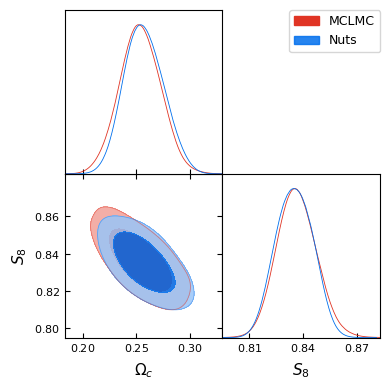

In [38]:
# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity
%matplotlib inline
names = ["omegac", 's8']
labels =  [r"\Omega_{c}", r'S_8']
from getdist import plots, MCSamples
import getdist
samples = MCSamples(samples=sall[:],names = names, labels=labels,label = 'MCLMC')

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples, samples2], filled=True)
